In [1]:
# import need packages
from __future__ import annotations
from typing import List, Tuple, Dict, Any, Optional, Iterable, Set
import math
import itertools
import numpy as np

try:
    from scipy.optimize import milp, Bounds, LinearConstraint
    import numpy as np
    from scipy import sparse
    HAS_SCIPY_MILP = True
except Exception:
    HAS_SCIPY_MILP = False


try:
    from ortools.sat.python import cp_model
    _HAS_ORTOOLS = True
except Exception:
    _HAS_ORTOOLS = False

In [2]:
_LAST_SOLVER_USED = "unknown"

def get_last_solver_used() -> str:
    return _LAST_SOLVER_USED


# =========================
# Basic utilities
# =========================
Node = Tuple[int, int]  # (spectrum_index, peak_index)

def ppm_err(mz_a: float, mz_b: float) -> float:
    """Absolute ppm error |a - b| / max(b,1e-9) * 1e6"""
    return abs(mz_a - mz_b) / max(mz_b, 1e-9) * 1e6

def transform_intensity(i: float, mode: str = "sqrt") -> float:
    i = max(float(i), 0.0)
    if mode == "sqrt":
        return math.sqrt(i)
    if mode == "log1p":
        return math.log1p(i)
    if mode == "raw":
        return i
    raise ValueError(mode)

def _l2_normalize(vals, eps: float = 1e-12):
    nrm = norm = np.linalg.norm(vals)
    if nrm <= eps:
        return [0.0 for _ in vals]
    return [x / nrm for x in vals]


# =========================
# Multi-edge k-partite graph
# =========================
class KPartiteGraph:
    """
    k-partite peak graph with **multi-edges** (edge variants per node pair).
    For each unordered node pair {u,v}, we store a list of variants:
        {'w': weight, 'ppm': ppm_error, 'shifted': 0/1, 'mode': 'unshift'|'shift'}
    """
    def __init__(self):
        self.partitions: List[List[Node]] = []                 # nodes per spectrum
        self.node_attr: Dict[Node, Dict[str, float]] = {}      # {'mz':..., 'I':...}
        self.edges_multi: Dict[frozenset, List[Dict[str, float]]] = {}

    def add_partition(self, nodes: List[Node]):
        self.partitions.append(nodes)

    def add_node(self, node: Node, mz: float, I_tilde: float):
        self.node_attr[node] = {"mz": float(mz), "I": float(I_tilde)}

    def add_edge_variant(self, u: Node, v: Node, *, w: float, ppm: float, shifted: float, mode: str):
        if u[0] == v[0]:
            return  # never connect within same spectrum
        key = frozenset((u, v))
        self.edges_multi.setdefault(key, []).append(
            {"w": float(w), "ppm": float(ppm), "shifted": float(shifted), "mode": mode}
        )

    def neighbors_of(self, node: Node) -> Set[Node]:
        nbrs: Set[Node] = set()
        for key, variants in self.edges_multi.items():
            if not variants:
                continue
            if node in key:
                for other in key:
                    if other != node:
                        nbrs.add(other)
        return nbrs

    def edge_variants(self, u: Node, v: Node) -> List[Dict[str, float]]:
        return self.edges_multi.get(frozenset((u, v)), [])


# =========================
# Build graph (alignment step)
# =========================
def build_graph_from_spectra(
    spectra: List[Dict[str, Any]],
    ppm_tol: float = 10.0,
    intensity_mode: str = "sqrt",
    match_strategy: str = "nearest",   # "nearest" or "all_within_tol"
    use_precursor_shift: bool = True,  # enable "shift" = precursor_mz difference
    lambda_shift: float = 0.0,         # set to 0 for **no preference**
    max_partitions: Optional[int] = None,
) -> KPartiteGraph:
    """
    Create a k-partite graph where:
      - Node = a peak (mz, intensity-transformed)
      - For every cross-spectrum peak pair, we **independently** test:
          (A) unshift: |mz_p - mz_q| <= ppm_tol
          (B) shift:   |mz_p - (mz_q + Δprec)| <= ppm_tol, Δprec=prec_mz(s)-prec_mz(t)  (if enabled)
        Every satisfied condition adds **its own variant edge**; i.e., the same node pair
        may have two edges (unshift + shift). A node may connect to **multiple** opposite peaks.
      - Edge weight: w = sqrt(I_p) * sqrt(I_q)  (minus lambda_shift if shifted and you want that; set 0 to disable)
    """
    if max_partitions is not None:
        spectra = spectra[:max_partitions]

    G = KPartiteGraph()

    # Register nodes
    partitions: List[List[Node]] = []
    mz_lists: List[List[float]] = []
    for si, spec in enumerate(spectra):
        peaks = sorted(spec.get("peaks", []), key=lambda x: x[0])
        nodes: List[Node] = []
        mzs: List[float] = []
        mzs = [float(mz) for mz, _ in peaks]
        I_tilde_list = [transform_intensity(inten, intensity_mode) for _, inten in peaks]
        I_tilde_list = _l2_normalize(I_tilde_list, eps=1e-12)
        # for pi, (mz, inten) in enumerate(peaks):
        #     node = (si, pi)
        #     nodes.append(node)
        #     mzs.append(float(mz))
        #     # I_tilde = transform_intensity(inten, intensity_mode)
        #     G.add_node(node, mz=float(mz), I_tilde=I_tilde)  # store as 'I'
        #     G.node_attr[node]["I"] = I_tilde
        for pi, (mz, I_tilde) in enumerate(zip(mzs, I_tilde_list)):
            node = (si, pi)
            nodes.append(node)
            G.add_node(node, mz=mz, I_tilde=I_tilde)
            G.node_attr[node]["I"] = I_tilde
        partitions.append(nodes)
        mz_lists.append(mzs)
        G.add_partition(nodes)

    # Pairwise alignment → add variants
    k = len(spectra)
    for si, ti in itertools.combinations(range(k), 2):
        s_nodes = partitions[si]; t_nodes = partitions[ti]
        s_mz = mz_lists[si];      t_mz = mz_lists[ti]
        prec_s = float(spectra[si].get("precursor_mz", 0.0))
        prec_t = float(spectra[ti].get("precursor_mz", 0.0))
        delta_prec = prec_s - prec_t

        if match_strategy == "nearest":
            j = 0
            for i, mz_i in enumerate(s_mz):
                while j + 1 < len(t_mz) and abs(t_mz[j + 1] - mz_i) < abs(t_mz[j] - mz_i):
                    j += 1
                for jj in (j - 1, j, j + 1):
                    if 0 <= jj < len(t_mz):
                        mz_j = t_mz[jj]
                        u = s_nodes[i]; v = t_nodes[jj]
                        # unshift
                        ppm0 = ppm_err(mz_i, mz_j)
                        if ppm0 <= ppm_tol:
                            w = G.node_attr[u]["I"] * G.node_attr[v]["I"]
                            G.add_edge_variant(u, v, w=w, ppm=ppm0, shifted=0.0, mode="unshift")
                        # shift
                        if use_precursor_shift:
                            ppm_shift = ppm_err(mz_i, mz_j + delta_prec)
                            if ppm_shift <= ppm_tol:
                                w = G.node_attr[u]["I"] * G.node_attr[v]["I"]
                                if lambda_shift > 0.0:
                                    w -= lambda_shift  # set 0.0 if no preference
                                G.add_edge_variant(u, v, w=w, ppm=ppm_shift, shifted=1.0, mode="shift")

        elif match_strategy == "all_within_tol":
            j = 0
            for i, mz_i in enumerate(s_mz):
                while j < len(t_mz) and t_mz[j] < mz_i * (1 - ppm_tol / 1e6) - 1e-9:
                    j += 1
                jj = j
                while jj < len(t_mz):
                    mz_j = t_mz[jj]
                    # quick right boundary check
                    if mz_j > mz_i * (1 + ppm_tol / 1e6) + 1e-9 and (not use_precursor_shift or
                        (mz_j + delta_prec) > mz_i * (1 + ppm_tol / 1e6) + 1e-9):
                        break
                    u = s_nodes[i]; v = t_nodes[jj]
                    ppm0 = ppm_err(mz_i, mz_j)
                    if ppm0 <= ppm_tol:
                        w = G.node_attr[u]["I"] * G.node_attr[v]["I"]
                        G.add_edge_variant(u, v, w=w, ppm=ppm0, shifted=0.0, mode="unshift")
                    if use_precursor_shift:
                        ppm_shift = ppm_err(mz_i, mz_j + delta_prec)
                        if ppm_shift <= ppm_tol:
                            w = G.node_attr[u]["I"] * G.node_attr[v]["I"]
                            if lambda_shift > 0.0:
                                w -= lambda_shift
                            G.add_edge_variant(u, v, w=w, ppm=ppm_shift, shifted=1.0, mode="shift")
                    jj += 1
        else:
            raise ValueError("match_strategy must be 'nearest' or 'all_within_tol'")

    return G


# =========================
# Clique enumeration & scoring
# =========================
def best_pair_weight(G: KPartiteGraph, u: Node, v: Node) -> float:
    """Return the **best** (max) weight among all edge variants between u and v, or -inf if none."""
    variants = G.edge_variants(u, v)
    if not variants:
        return float("-inf")
    return max(ed["w"] for ed in variants)

def enumerate_kpartite_cliques(
    G: KPartiteGraph, m_min: int = 3, max_solutions: Optional[int] = None
) -> List[Tuple[List[Node], float]]:
    """
    Enumerate feasible cliques with size >= m_min, one node per spectrum.
    Score of a clique = sum over all pairs **best_pair_weight(u,v)** (choose the best variant per pair).
    """
    partitions = G.partitions
    k = len(partitions)

    # precompute neighbors (existence of at least one variant)
    nbrs: Dict[Node, Set[Node]] = {n: G.neighbors_of(n) for part in partitions for n in part}
    results: List[Tuple[List[Node], float]] = []

    def clique_score(nodes: List[Node]) -> float:
        s = 0.0
        for u, v in itertools.combinations(nodes, 2):
            w = best_pair_weight(G, u, v)
            if not math.isfinite(w):
                return float("-inf")
            s += w
        return s

    # DFS over partitions
    def dfs(pidx: int, current: List[Node]) -> bool:
        if pidx == k:
            if len(current) >= m_min:
                results.append((current.copy(), clique_score(current)))
                if max_solutions and len(results) >= max_solutions:
                    return True
            return False

        # Candidates in this partition: must connect to all nodes in current
        if not current:
            candidates = partitions[pidx]
        else:
            allowed = None
            for u in current:
                cand_u = {v for v in nbrs[u] if v[0] == pidx}
                allowed = cand_u if allowed is None else (allowed & cand_u)
                if not allowed:
                    break
            candidates = sorted(allowed, key=lambda n: -G.node_attr[n]["I"]) if allowed else []

        # Option 1: skip this partition (only if we can still reach m_min)
        max_possible = len(current) + (k - pidx - 1) + (1 if candidates else 0)
        if max_possible >= m_min:
            if dfs(pidx + 1, current):
                return True

        # Option 2: try each candidate
        for node in candidates:
            current.append(node)
            if dfs(pidx + 1, current):
                return True
            current.pop()
        return False

    dfs(0, [])
    # keep valid & sort by score
    results = [r for r in results if math.isfinite(r[1])]
    results.sort(key=lambda x: -x[1])
    return results


# =========================
# Set packing (global optimal selection of disjoint cliques)
# =========================
def select_disjoint_cliques_old(
    cliques: List[Tuple[List[Node], float]],
    use_ortools: Optional[bool] = None,
    time_limit_s: float = 10.0,
    workers: int = 8,
) -> List[Tuple[List[Node], float]]:
    """
    Maximum-weight set packing: pick disjoint cliques to maximize total score.
    Uses OR-Tools CP-SAT if available, else falls back to greedy.
    """
    if use_ortools is None:
        use_ortools = HAS_ORTOOLS

    if not cliques:
        return []

    # Index which cliques contain each peak
    peak_to_clqs: Dict[Node, List[int]] = {}
    for ci, (C, _) in enumerate(cliques):
        for v in C:
            peak_to_clqs.setdefault(v, []).append(ci)

    if use_ortools:
        model = cp_model.CpModel()
        z = [model.NewBoolVar(f"z_{i}") for i in range(len(cliques))]
        # non-overlap
        for v, idxs in peak_to_clqs.items():
            model.Add(sum(z[i] for i in idxs) <= 1)
        # objective
        # scale weights to integers
        w_int = [int(round(score * 1000)) for (_, score) in cliques]
        model.Maximize(sum(w_int[i] * z[i] for i in range(len(cliques))))
        solver = cp_model.CpSolver()
        solver.parameters.max_time_in_seconds = time_limit_s
        solver.parameters.num_search_workers = max(1, workers)
        status = solver.Solve(model)
        picked: List[Tuple[List[Node], float]] = []
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            for i, var in enumerate(z):
                if solver.Value(var) == 1:
                    picked.append(cliques[i])
        return picked

    # Greedy fallback
    used: Set[Node] = set()
    picked: List[Tuple[List[Node], float]] = []
    for C, w in cliques:
        if any(v in used for v in C):
            continue
        picked.append((C, w))
        used.update(C)
    return picked

def select_disjoint_cliques(
    cliques: List[Tuple[List[Node], float]],
    use_ortools: Optional[bool] = None,
    time_limit_s: float = 10.0,
    workers: int = 8,
) -> List[Tuple[List[Node], float]]:
    """
    Maximum-weight set packing: pick disjoint cliques to maximize total score.
    Priority: SciPy MILP (HiGHS) -> OR-Tools (if explicitly requested/available) -> greedy.
    """
    global _LAST_SOLVER_USED
    if not cliques:
        return []

   
    peak_to_clqs: Dict[Node, List[int]] = {}
    for ci, (C, _) in enumerate(cliques):
        for v in C:
            peak_to_clqs.setdefault(v, []).append(ci)

  
    if HAS_SCIPY_MILP:
        _LAST_SOLVER_USED = "scipy-milp(highs)"
        n = len(cliques)
       
        w = np.array([score for (_, score) in cliques], dtype=float)
        c = -w

        
        integrality = np.ones(n, dtype=int)
        bounds = Bounds(lb=np.zeros(n), ub=np.ones(n))


        rows = []
        cols = []
        vals = []
        row_ub = []
        for r, idxs in enumerate(peak_to_clqs.values()):
            for i in idxs:
                rows.append(r)
                cols.append(i)
                vals.append(1.0)
            row_ub.append(1.0)

        if rows:
            A = sparse.csr_matrix((vals, (rows, cols)), shape=(len(row_ub), n))
            constraints = LinearConstraint(A, lb=-np.inf, ub=np.array(row_ub, dtype=float))
        else:
            
            constraints = None

      
        options = {"time_limit": float(time_limit_s)}

        res = milp(c=c, integrality=integrality, bounds=bounds,
                   constraints=constraints, options=options)

        picked: List[Tuple[List[Node], float]] = []
        if res.success and res.x is not None:
            z = (res.x >= 0.5)  
            for i, take in enumerate(z):
                if take:
                    picked.append(cliques[i])
        else:

            _LAST_SOLVER_USED = "greedy(fallback)"
            used: Set[Node] = set()
            for C, w_i in cliques:
                if any(v in used for v in C):
                    continue
                picked.append((C, w_i))
                used.update(C)
        return picked

    use_ortools = (use_ortools is True) and HAS_ORTOOLS
    if use_ortools:
        _LAST_SOLVER_USED = "ortools-cpsat"
        model = cp_model.CpModel()
        z = [model.NewBoolVar(f"z_{i}") for i in range(len(cliques))]
        for v, idxs in peak_to_clqs.items():
            model.Add(sum(z[i] for i in idxs) <= 1)
        w_int = [int(round(score * 1000)) for (_, score) in cliques]
        model.Maximize(sum(w_int[i] * z[i] for i in range(len(cliques))))
        solver = cp_model.CpSolver()
        solver.parameters.max_time_in_seconds = time_limit_s
        solver.parameters.num_search_workers = max(1, workers)
        status = solver.Solve(model)
        picked: List[Tuple[List[Node], float]] = []
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            for i, var in enumerate(z):
                if solver.Value(var) == 1:
                    picked.append(cliques[i])
        return picked

    _LAST_SOLVER_USED = "greedy"
    used: Set[Node] = set()
    picked: List[Tuple[List[Node], float]] = []
    for C, w in cliques:
        if any(v in used for v in C):
            continue
        picked.append((C, w))
        used.update(C)
    return picked



# =========================
# End-to-end helper
# =========================
def global_peak_sets(
    spectra: List[Dict[str, Any]],
    ppm_tol: float = 10.0,
    intensity_mode: str = "sqrt",
    match_strategy: str = "nearest",
    use_precursor_shift: bool = True,
    lambda_shift: float = 0.0,       # set 0 to **disable** any preference
    m_min: int = 3,
    use_ortools: Optional[bool] = None,
) -> Dict[str, Any]:
    G = build_graph_from_spectra(
        spectra, ppm_tol=ppm_tol, intensity_mode=intensity_mode,
        match_strategy=match_strategy, use_precursor_shift=use_precursor_shift,
        lambda_shift=lambda_shift
    )
    cliques = enumerate_kpartite_cliques(G, m_min=m_min)
    selected = select_disjoint_cliques(cliques, use_ortools=use_ortools)
    return {"graph": G, "cliques_sorted": cliques, "selected_sets": selected,"solver_used": get_last_solver_used()}


In [3]:
# Visualization Functions
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_kpartite_graph(
    G,
    annotate: bool = True,
    node_size_scale: float = 1.0,
    edge_alpha: float = 0.4,
    weight_scale: bool = True,
    figsize=(12, 6),
    savepath: str | None = None,
):
    """
    Visualize a KPartiteGraph with multi-edge variants.
    Expects:
      - G.partitions: List[List[Node]]
      - G.node_attr[n]: {'mz': float, 'I': float}  (I is transformed intensity)
      - G.edges_multi: {frozenset({u,v}): [ {'w':..., 'ppm':..., 'shifted':0/1, 'mode':'unshift'|'shift'}, ... ]}
    """
    partitions = G.partitions
    k = len(partitions)
    if k == 0:
        raise ValueError("Graph has no partitions.")

    # collect ranges
    all_mz = [G.node_attr[n]["mz"] for part in partitions for n in part]
    all_I  = [G.node_attr[n]["I"]  for part in partitions for n in part]
    if not all_mz:
        raise ValueError("Graph has no nodes.")
    mz_min, mz_max = min(all_mz), max(all_mz)
    I_max = max(all_I) if all_I else 1.0

    def y_from_mz(mz):
        if mz_max == mz_min:
            return 0.5
        return (mz - mz_min) / (mz_max - mz_min)

    # coordinates per node
    coords = {}
    for s_idx, part in enumerate(partitions):
        x = s_idx
        for n in part:
            coords[n] = (x, y_from_mz(G.node_attr[n]["mz"]))

    # edge weight range → line width
    ws = [ed["w"] for variants in G.edges_multi.values() for ed in variants] or [1.0]
    w_min, w_max = min(ws), max(ws)

    def lw_from_w(w):
        if not weight_scale or w_max <= w_min:
            return 1.2
        return 0.6 + 2.6 * (w - w_min) / (w_max - w_min)

    # draw
    fig, ax = plt.subplots(figsize=figsize)

    # vertical guides
    for x in range(k):
        ax.plot([x, x], [-0.05, 1.05], linewidth=1, alpha=0.2)

    # edges (draw each variant)
    for key, variants in G.edges_multi.items():
        if not variants: 
            continue
        u, v = tuple(key)
        x1, y1 = coords[u]
        x2, y2 = coords[v]
        for ed in variants:
            ls = '-' if str(ed.get("mode", "unshift")) == "unshift" else '--'
            ax.plot([x1, x2], [y1, y2], linestyle=ls, linewidth=lw_from_w(ed["w"]), alpha=edge_alpha)

    # nodes (one scatter per spectrum so matplotlib auto-colors per spectrum)
    for s_idx, part in enumerate(partitions):
        xs = [coords[n][0] for n in part]
        ys = [coords[n][1] for n in part]
        sizes = [max(10.0, 40.0 * (G.node_attr[n]["I"] / (I_max or 1.0))) * node_size_scale for n in part]
        ax.scatter(xs, ys, s=sizes, zorder=3)
        if annotate:
            for n in part:
                x, y = coords[n]
                mz = G.node_attr[n]["mz"]; I = G.node_attr[n]["I"]
                ax.text(x, y + 0.015, f"{mz:.4f}\n{I:.2g}", fontsize=7, ha='center', va='bottom')

    # axes & legend
    ax.set_xlim(-0.5, k - 0.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(range(k))
    ax.set_xticklabels([f"S{s}" for s in range(k)])
    ax.set_yticklabels([])
    ax.set_title("k-partite peak graph (solid=unshift, dashed=shift)")

    legend_lines = [
        Line2D([0], [0], linestyle='-',  linewidth=2, label='unshift edge'),
        Line2D([0], [0], linestyle='--', linewidth=2, label='shift edge'),
    ]
    ax.legend(handles=legend_lines, loc='upper right', frameon=False, fontsize=8)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def visualize_kpartite_graph_polygon(
    G,
    cliques=None,           
    highlight_idx=None,     
    annotate=True,
    node_size_scale=1.0,
    edge_alpha=0.25,
    figsize=(9, 9),
    savepath=None,
):

    parts = G.partitions
    k = len(parts)
    if k < 3:
        raise ValueError("Polygon view requires at least 3 spectra (k>=3).")


    verts = [(math.cos(2*math.pi*i/k), math.sin(2*math.pi*i/k)) for i in range(k)]

    segs = [(verts[i], verts[(i+1) % k]) for i in range(k)]


    coords = {}
    for i, part in enumerate(parts):
        mzs = [G.node_attr[n]["mz"] for n in part]
        if not mzs:
            continue
        mz_min, mz_max = min(mzs), max(mzs)
        (ax, ay), (bx, by) = segs[i]
        for n in sorted(part, key=lambda n: G.node_attr[n]["mz"]):
            mz = G.node_attr[n]["mz"]
            t = 0.5 if mz_max == mz_min else (mz - mz_min) / (mz_max - mz_min)
            x = ax + t * (bx - ax)
            y = ay + t * (by - ay)
            coords[n] = (x, y)


    ws = [ed["w"] for variants in G.edges_multi.values() for ed in variants] or [1.0]
    w_min, w_max = min(ws), max(ws)
    def lw_from_w(w):
        if w_max <= w_min:
            return 0.8
        return 0.4 + 2.2 * (w - w_min) / (w_max - w_min)

    fig, ax = plt.subplots(figsize=figsize)


    for (a, b) in segs:
        ax.plot([a[0], b[0]], [a[1], b[1]], linewidth=2, alpha=0.25)


    for key, variants in G.edges_multi.items():
        u, v = tuple(key)
        if u not in coords or v not in coords:
            continue
        x1, y1 = coords[u]; x2, y2 = coords[v]
        for ed in variants:
            ls = '-' if str(ed.get("mode", "unshift")) == "unshift" else '--'
            ax.plot([x1, x2], [y1, y2], linestyle=ls, linewidth=lw_from_w(ed["w"]), alpha=edge_alpha)

    if cliques is not None and highlight_idx is not None:
        idxs = [highlight_idx] if isinstance(highlight_idx, int) else list(highlight_idx)
        for idx in idxs:
            nodes = cliques[idx][0] if (isinstance(cliques[idx], (list, tuple)) and len(cliques[idx]) == 2) else cliques[idx]
            for i in range(len(nodes)):
                for j in range(i+1, len(nodes)):
                    u, v = nodes[i], nodes[j]
                    if u in coords and v in coords:
                        variants = G.edge_variants(u, v)
                        if not variants:
                            continue
                        best = max(variants, key=lambda ed: ed["w"])
                        ls = '-' if str(best.get("mode", "unshift")) == "unshift" else '--'
                        ax.plot([coords[u][0], coords[v][0]], [coords[u][1], coords[v][1]],
                                linestyle=ls, linewidth=3.5, alpha=0.9)


    for i, part in enumerate(parts):
        pts = [n for n in part if n in coords]
        xs = [coords[n][0] for n in pts]
        ys = [coords[n][1] for n in pts]
        Is = [G.node_attr[n]["I"] for n in pts]
        Imax = max(Is) if Is else 1.0
        sizes = [max(10.0, 40.0 * (I / (Imax or 1.0))) * node_size_scale for I in Is]
        ax.scatter(xs, ys, s=sizes, zorder=3)
        if annotate:
            for n in pts:
                x, y = coords[n]
                mz = G.node_attr[n]["mz"]; I = G.node_attr[n]["I"]
                ax.text(x, y + 0.02, f"{mz:.4f}\n{I:.2g}", fontsize=7, ha='center', va='bottom')

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.axis('off')
    ax.set_title("Polygon view: each side = one spectrum (solid=unshift, dashed=shift)")

    legend_lines = [
        Line2D([0],[0], linestyle='-',  linewidth=2, label='unshift edge'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='shift edge'),
    ]
    ax.legend(handles=legend_lines, loc='upper right', frameon=False, fontsize=8)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()


In [4]:
# import data for the Albicidin family in the paper
from modifinder.utilities import network
usi1 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:4873'
usi2 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:4965'
usi3 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:5325'
usi4 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:5209'
usi5 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:3613'
usi6 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:5610'
usi7 = 'mzspec:GNPS2:TASK-c345b38b7d334628847d13eba2860e3e-nf_output/clustering/specs_ms.mgf:scan:5089'
s1 = network.get_data(usi1)
s2 = network.get_data(usi2)
s3 = network.get_data(usi3)
s4 = network.get_data(usi4)
s5 = network.get_data(usi5)
s6 = network.get_data(usi6)
s7 = network.get_data(usi7)
spectra_albicidin = [s1,s2,s3,s4,s5,s6,s7]
G_albicidin = build_graph_from_spectra(spectra_albicidin, ppm_tol=100.0, match_strategy="nearest",
                             use_precursor_shift=True, lambda_shift=0.0)

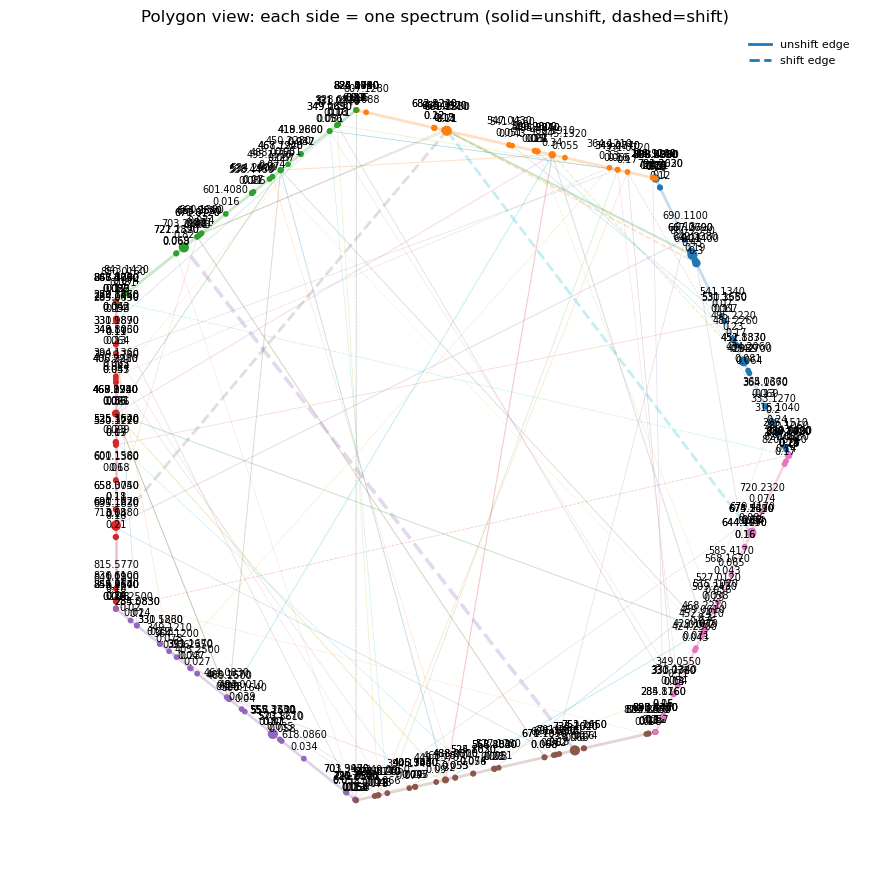

In [5]:
visualize_kpartite_graph_polygon(G_albicidin)

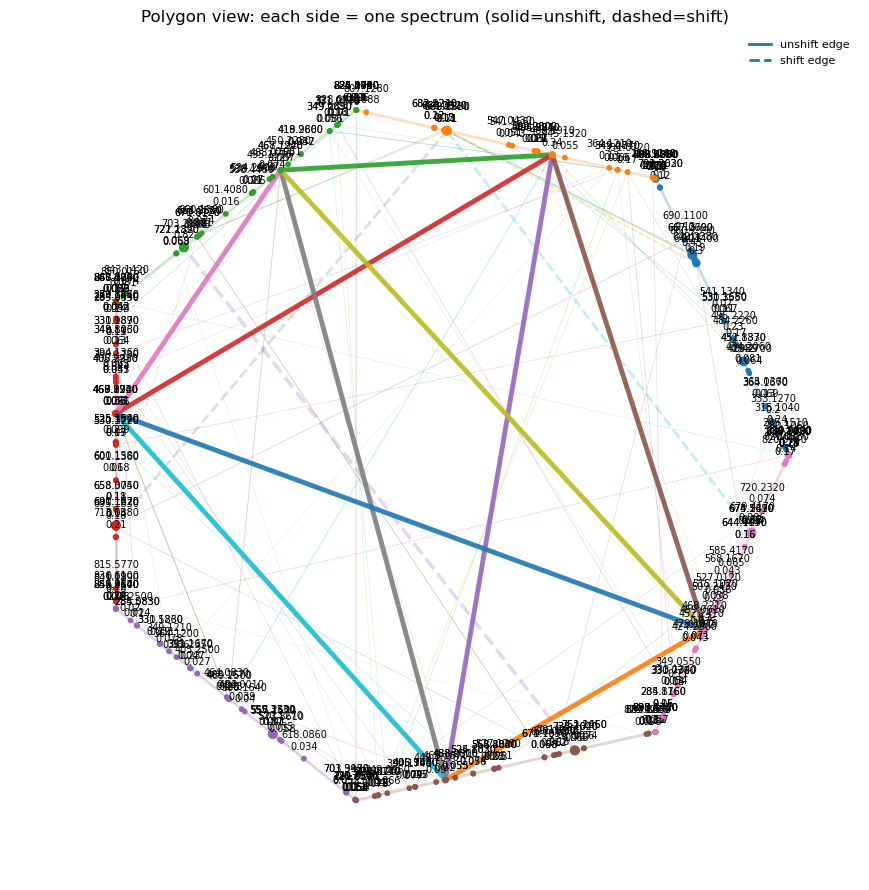

In [6]:
cliques_albicidin = enumerate_kpartite_cliques(G_albicidin, m_min=3)
visualize_kpartite_graph_polygon(G_albicidin, cliques=cliques_albicidin, highlight_idx=0)

In [7]:
out_cliques_albicidin = global_peak_sets(
    spectra_albicidin,
    ppm_tol=100.0,            # adjust as needed
    intensity_mode="sqrt",
    match_strategy="nearest", # or "all_within_tol" (denser graph)
    use_precursor_shift=True, # keep both unshift and shift variants
    lambda_shift=0.0,         # **no preference** between unshift/shift here
    m_min=3,                  # min support (spectra) per set
)
print("solver used:", get_last_solver_used())

solver used: scipy-milp(highs)


In [8]:
print("\nSelected disjoint sets")
for C, w in out_cliques_albicidin["selected_sets"]:
    members = [f"S{s}[{p}]" for (s, p) in C]
    print(f"  score={w:.3f}  |  {' '.join(members)}")


Selected disjoint sets
  score=1.018  |  S1[8] S2[10] S3[14] S5[11] S6[11]
  score=0.151  |  S1[3] S2[2] S5[4] S6[4]
  score=0.046  |  S2[0] S3[4] S5[0]
  score=0.041  |  S1[4] S2[4] S6[6]
  score=0.024  |  S3[8] S4[6] S5[5]


In [9]:
# import data for the Rhamnolipids family in the paper
# scan number: 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898
from modifinder.utilities import network
usi_1 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6878'
usi_2 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6052'
usi_3 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6806'
usi_4 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:8214'
usi_5 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6812'
usi_6 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:8367'
usi_7 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:8372'
usi_8 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:8377'
usi_9 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:5930'
usi_10 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6269'
usi_11 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6900'
usi_12 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:8395'
usi_13 = 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-nf_output/clustering/specs_ms.mgf:scan:6898'
s_1 = network.get_data(usi_1)
s_2 = network.get_data(usi_2)
s_3 = network.get_data(usi_3)
s_4 = network.get_data(usi_4)
s_5 = network.get_data(usi_5)
s_6 = network.get_data(usi_6)
s_7 = network.get_data(usi_7)
s_8 = network.get_data(usi_8)
s_9 = network.get_data(usi_9)
s_10 = network.get_data(usi_10)
s_11 = network.get_data(usi_11)
s_12 = network.get_data(usi_12)
s_13 = network.get_data(usi_13)
spectra_rhamnolipids = [s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13]
G_rhamnolipids = build_graph_from_spectra(spectra_rhamnolipids, ppm_tol=100.0, match_strategy="nearest",
                             use_precursor_shift=True, lambda_shift=0.0)

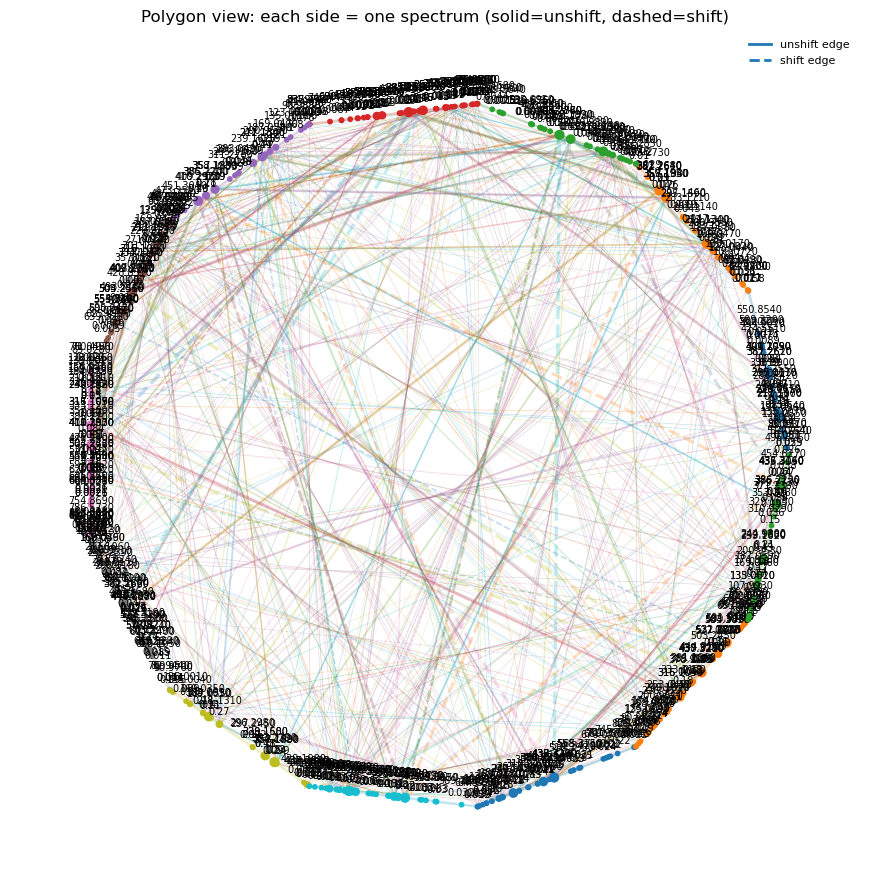

In [10]:
visualize_kpartite_graph_polygon(G_rhamnolipids)

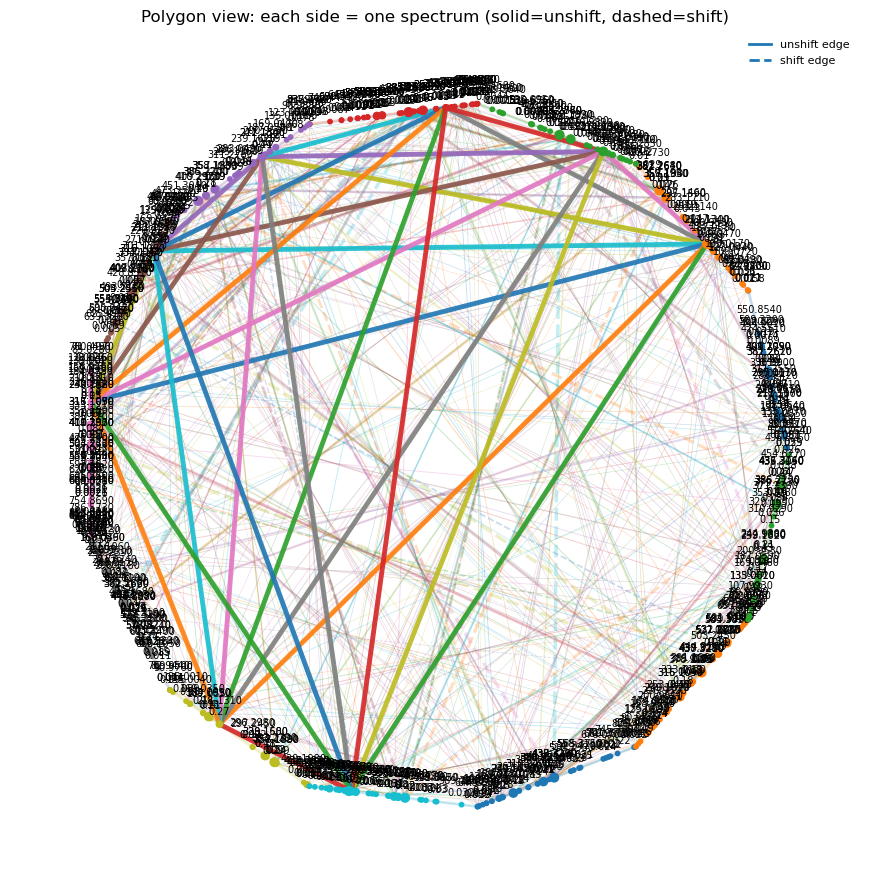

In [11]:
cliques_rhamnolipids = enumerate_kpartite_cliques(G_rhamnolipids, m_min=3)
visualize_kpartite_graph_polygon(G_rhamnolipids, cliques=cliques_rhamnolipids, highlight_idx=0)

In [12]:
# use scipy-milp optimizer to slove 
out_cliques_rhamnolipids = global_peak_sets(
    spectra_rhamnolipids,
    ppm_tol=100.0,            # adjust as needed
    intensity_mode="sqrt",
    match_strategy="nearest", # or "all_within_tol" (denser graph)
    use_precursor_shift=True, # keep both unshift and shift variants
    lambda_shift=0.0,         # **no preference** between unshift/shift here
    m_min=3,                  # min support (spectra) per set
)
print("solver used:", get_last_solver_used())

solver used: scipy-milp(highs)


In [13]:
# results for rhamnolipids family
print("\nSelected disjoint sets")
for C, w in out_cliques_rhamnolipids["selected_sets"]:
    members = [f"S{s}[{p}]" for (s, p) in C]
    print(f"  score={w:.3f}  |  {' '.join(members)}")


Selected disjoint sets
  score=2.880  |  S1[12] S2[7] S3[11] S4[9] S5[10] S6[7] S8[8] S9[10]
  score=2.570  |  S1[18] S2[14] S3[19] S4[16] S5[19] S6[15] S8[15] S9[18] S10[15]
  score=1.491  |  S0[4] S2[4] S3[7] S4[5] S5[6] S6[3] S7[6] S8[3] S9[5] S10[5] S11[4] S12[5]
  score=1.314  |  S2[16] S4[20] S9[21] S12[20]
  score=1.262  |  S1[8] S2[5] S3[8] S4[6] S5[7] S6[5] S7[8] S8[4] S10[6] S11[6] S12[6]
  score=1.241  |  S0[17] S1[21] S3[20] S7[18]
  score=1.188  |  S3[15] S5[15] S6[11] S11[13]
  score=0.849  |  S4[11] S6[9] S10[9] S11[10] S12[10]
  score=0.845  |  S1[9] S2[6] S4[7] S5[8] S8[7] S9[8] S10[8] S12[8]
  score=0.801  |  S5[20] S6[17] S7[20] S11[19]
  score=0.664  |  S4[18] S6[16] S10[18] S11[17] S12[18]
  score=0.551  |  S1[11] S3[10] S4[8] S5[9] S9[9] S11[8] S12[9]
  score=0.366  |  S3[25] S5[25] S6[22] S11[23]
  score=0.319  |  S3[28] S5[28] S6[25]
  score=0.296  |  S0[18] S1[22] S3[21] S7[19]
  score=0.254  |  S1[19] S2[15] S4[17] S8[16] S9[19]
  score=0.223  |  S0[8] S1[13]

In [14]:
# Alignment benchmark (GNPS2 task) using source functions
from pathlib import Path
import io
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append(str(Path.cwd() / 'NetworkFamily_MultipleAlignment_Website'))
from alignment import get_data, get_topo_path, get_sets, new_matches, add_pairs

TASK_ID = 'c345b38b7d334628847d13eba2860e3e'

# Discover components and sizes
pairs_url = f'https://gnps2.org/resultfile?task={TASK_ID}&file=nf_output/networking/pairs_with_components.tsv'
resp = requests.get(pairs_url)
resp.raise_for_status()
df_pairs = pd.read_csv(io.BytesIO(resp.content), sep='\t')
df_pairs = df_pairs[['CLUSTERID1', 'CLUSTERID2', 'ComponentIndex']]

component_to_scans = {}
for comp, sub in df_pairs.groupby('ComponentIndex'):
    scans = set(sub['CLUSTERID1'].astype(int)).union(set(sub['CLUSTERID2'].astype(int)))
    component_to_scans[int(comp)] = sorted(scans)

# Benchmark per component
results = []
for comp in sorted(component_to_scans.keys()):
    t0 = time.perf_counter()
    fspec, df_comp, scans = get_data(comp, TASK_ID)
    t1 = time.perf_counter()
    topo, aligns = get_topo_path(fspec, df_comp, scans)
    t2 = time.perf_counter()
    trans_sets = get_sets(topo, aligns)
    npairs = new_matches(topo, fspec)
    final_sets = add_pairs(trans_sets, npairs)
    t3 = time.perf_counter()
    results.append({'component': comp, 'size': len(scans), 't_get_data': t1-t0, 't_align_path': t2-t1, 't_sets': t3-t2, 't_total': t3-t0})

results_df = pd.DataFrame(results)
results_df.head()


[5513, 5514, 5550, 5288, 5555, 5302, 5549, 5551, 4941, 5552, 5554, 4775, 4776, 5553, 4876, 5058, 5074, 5071, 3700, 5075, 2597, 5088, 2592, 2215, 2005, 1855, 3533, 5072, 3014, 1636, 1853, 3013, 2194, 3580]
[5634, 5229, 5598, 5153, 4852, 3969, 5748, 5562, 1926, 4673, 5739, 1260, 5911, 3613, 4983, 5784, 5353, 5440, 5829, 5325, 3777, 4023, 4965, 5089, 2123, 3646, 5490, 4043, 5351, 5674, 4205, 5610, 5348, 3867, 3836, 4873, 2023, 4991, 2981, 5161, 3794, 5352, 5101, 5209, 5476, 5103, 1998, 1768, 4221, 5806, 5656, 4986, 5354, 5270, 5091, 4076, 1999, 1550, 1966, 4804, 5814, 5647, 5245, 1158]
[2948, 3367, 1223, 3290, 1735]
[3093, 2636, 3116, 3497, 2226, 2239, 3048, 3059, 2611, 2634, 2339, 2265, 3498, 3129, 3050, 3066, 3049, 3051, 2613, 2675, 3004, 3058, 3100, 3187, 2646]
[2972, 3441, 2991, 3627, 3628, 3485, 3487, 3612, 3486]
[69, 1590, 1741, 1231, 1449, 1385, 1621, 1433, 1271, 1706, 3711, 1174, 1461]
[2562, 4027, 4662, 3412, 3842, 3858, 4299, 4694, 1702, 728, 3859, 4340, 4213, 1744, 4676, 4682, 

component  size  t_get_data  t_align_path    t_sets   t_total
0          1    34    0.430767      0.210532  0.194116  0.835414
1          2    64    0.228710      0.749570  0.751625  1.729904
2          3     5    0.438312      0.004213  0.002664  0.445189
3          5    25    0.420670      0.097792  0.091332  0.609794
4          6     9    0.390316      0.015451  0.010284  0.416051

size  count      mean    median       std
0     2     43  0.271121  0.279747  0.043708
1     3     18  0.282874  0.243178  0.074677
2     4     10  0.264909  0.259953  0.037867
3     5      5  0.373854  0.317712  0.082205
4     6      2  0.267285  0.267285  0.016960
5     7      2  0.249297  0.249297  0.023662
6     8      2  0.255086  0.255086  0.002659
7     9      4  0.363414  0.371733  0.080200
8    10      1  0.266227  0.266227       NaN
9    11      1  0.267656  0.267656       NaN

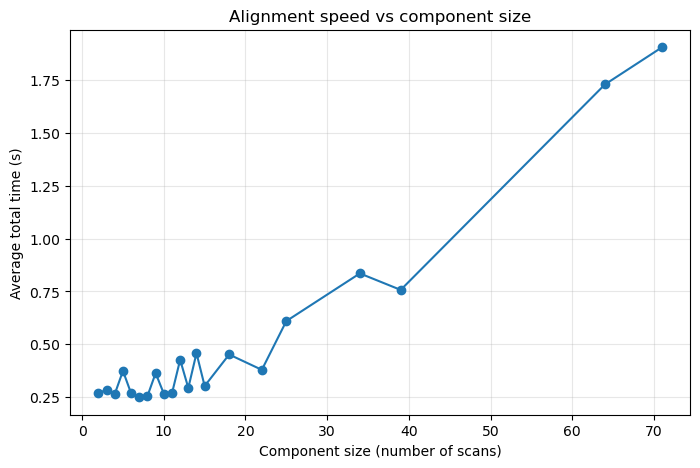

In [15]:
# Aggregate and plot speed vs component size
if results_df.empty:
    raise RuntimeError('No benchmark results to plot.')

agg = (results_df
       .groupby('size')['t_total']
       .agg(['count', 'mean', 'median', 'std'])
       .reset_index()
       .sort_values('size'))

display(agg.head(10))

plt.figure(figsize=(8, 5))
plt.plot(agg['size'], agg['mean'], marker='o', linestyle='-')
plt.xlabel('Component size (number of scans)')
plt.ylabel('Average total time (s)')
plt.title('Alignment speed vs component size')
plt.grid(True, alpha=0.3)
plt.show()


Model selection:
  O(n^2): R^2=0.9750, AIC=-45.36
  O(n log n): R^2=0.9615, AIC=-36.24
  O(n^3): R^2=0.9370, AIC=-25.92
  O(n): R^2=0.9335, AIC=-24.76
  O(1): R^2=-0.0000, AIC=32.14

Best model: O(n^2) with R^2=0.9750


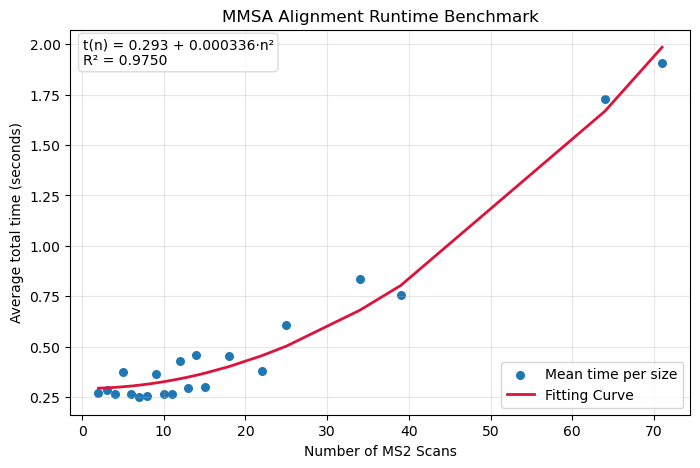

{'model': 'O(n^2)',
 'coef': array([0.29271833, 0.00033576]),
 'r2': 0.975043248200802,
 'aic': -45.358196153729494}

In [26]:
# Fit complexity models to timing vs size
import math
import numpy as np

# Use aggregated means per size for stability
if 'agg' not in locals():
    agg = (results_df
           .groupby('size')['t_total']
           .agg(['count', 'mean', 'median', 'std'])
           .reset_index()
           .sort_values('size'))

x = agg['size'].to_numpy(dtype=float)
y = agg['mean'].to_numpy(dtype=float)

# Candidate model features
features = {
    'O(1)': np.ones_like(x),
    'O(n)': x,
    'O(n log n)': x * np.log(np.maximum(x, 2.0)),
    'O(n^2)': x ** 2,
    'O(n^3)': x ** 3,
}

results_fit = []
for name, phi in features.items():
    Phi = np.vstack([np.ones_like(phi), phi]).T  # intercept + coefficient
    coef, residuals, rank, s = np.linalg.lstsq(Phi, y, rcond=None)
    y_hat = Phi @ coef
    ss_res = float(np.sum((y - y_hat) ** 2))
    ss_tot = float(np.sum((y - np.mean(y)) ** 2)) if len(y) > 1 else 0.0
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float('nan')
    n = len(y)
    k = len(coef)  # intercept + slope
    sigma2 = ss_res / max(n - k, 1)
    aic = n * (math.log(2 * math.pi * sigma2) + 1) + 2 * k if sigma2 > 0 else float('-inf')
    results_fit.append({'model': name, 'coef': coef, 'r2': r2, 'aic': aic})

# Rank by R^2 descending, then AIC ascending
results_fit_sorted = sorted(results_fit, key=lambda d: (-np.nan_to_num(d['r2'], nan=-1e9), d['aic']))
best = results_fit_sorted[0]
print('Model selection:')
for r in results_fit_sorted:
    print(f"  {r['model']}: R^2={r['r2']:.4f}, AIC={r['aic']:.2f}")
print(f"\nBest model: {best['model']} with R^2={best['r2']:.4f}")

# Plot aggregated means and best-fit curve
phi_best = features[best['model']]
Phi_best = np.vstack([np.ones_like(phi_best), phi_best]).T
y_fit = Phi_best @ best['coef']

# Build function string using Unicode superscripts (no TeX)
model_expr_ui = {
    'O(1)': '1',
    'O(n)': 'n',
    'O(n log n)': 'n·log n',
    'O(n^2)': 'n²',
    'O(n^3)': 'n³',
}[best['model']]
a0, a1 = float(best['coef'][0]), float(best['coef'][1])
func_ui = f"t(n) = {a0:.3g} + {a1:.3g}·{model_expr_ui}"
r2_ui = f"R² = {best['r2']:.4f}"

plt.figure(figsize=(8,5))
plt.scatter(x, y, s=30, label='Mean time per size')
plt.plot(x, y_fit, color='crimson', linewidth=2, label='Fitting Curve')
plt.xlabel('Number of MS2 Scans')
plt.ylabel('Average total time (seconds)')
plt.title('MMSA Alignment Runtime Benchmark')
plt.grid(True, alpha=0.3)
# Annotate function and R^2 (Unicode, no TeX)
ax = plt.gca()
ax.text(0.02, 0.98, func_ui + "\n" + r2_ui, transform=ax.transAxes,
        ha='left', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='lightgray'))
plt.legend()
plt.show()

best


In [141]:
# Build spec_dic using MMSA's processing approach (not website's filtering)
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'NetworkFamily_MultipleAlignment_Website'))

from usi import usi_processing
from alignment import get_data, get_topo_path, get_sets, new_matches, add_pairs

# Use the correct task and component for rhamnolipids
TASK_ID = '44e5488732e44a8599788ca2001896f6'
COMPONENT = 16

# Get data using the correct component (this gives us the proper topological ordering)
filtered_spec_dic, df_comp, scan_numbers = get_data(COMPONENT, TASK_ID)

# Exclude scan 3779 as requested
# scan_numbers = [s for s in scan_numbers if s != 3779]
# filtered_spec_dic = {k: v for k, v in filtered_spec_dic.items() if k != 3779}

# Convert to MMSA format: use raw spectra data with MMSA's processing (sqrt + L2 only)
# This matches how MMSA processes spectra in build_graph_from_spectra

# Compute path and peak sets using the same source functions
topo_path, alignments = get_topo_path(filtered_spec_dic, df_comp, scans)
transitive_sets = get_sets(topo_path, alignments)
new_pairs = new_matches(topo_path, filtered_spec_dic)
peak_sets = add_pairs(transitive_sets, new_pairs)

# Keep the largest 3 sets for highlighting
largest_sets = sorted(peak_sets, key=len, reverse=True)[:3]
max_mz = max(max(s.mz) for s in filtered_spec_dic.values())

print(f"Topological path: {topo_path}")
print(f"Number of peak sets: {len(peak_sets)}")
print(f"Largest set sizes: {[len(s) for s in largest_sets]}")
len(peak_sets), [len(s) for s in largest_sets]


[3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]
Topological path: [3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]
Number of peak sets: 57
Largest set sizes: [14, 13, 13]


(57, [14, 13, 13])

In [57]:
# Reproduce website-like stacked spectrum visualization with highlights and m/z labels
import plotly.graph_objects as go
from math import isnan

# Use topological order from alignment (not original scan order)
ordered_scans = topo_path

# Build one figure per spectrum similar to the web app
figs = []
for i, scan in enumerate(ordered_scans):
    if scan == 3779:
        continue
    spectrum = spec_dic[scan]
    mz = spectrum.mz
    intens = spectrum.intensity

    # default colors grey
    colors = ['#9aa0a6'] * len(mz)
    annotations = []

    # highlight top-3 largest sets in red/green/blue and collect annotations
    for idx, s in enumerate(largest_sets):
        color = ['#d62728', '#2ca02c', '#1f77b4'][idx]
        for (s_scan, p_idx) in s:
            if s_scan == scan and 0 <= p_idx < len(colors):
                colors[p_idx] = color
                # Add m/z label for highlighted peaks
                annotations.append(
                    dict(
                        x=mz[p_idx],
                        y=intens[p_idx] + 0.01,  # slightly above the peak
                        text=f"{mz[p_idx]:.3f}",
                        showarrow=False,
                        font=dict(size=8, color=color),
                        bgcolor="rgba(255,255,255,0.8)",
                        bordercolor=color,
                        borderwidth=1
                    )
                )

    show_x_labels = (i == len(ordered_scans) - 1)

    f = go.Figure()
    f.add_bar(x=mz, y=intens, marker_color=colors, hoverinfo='x+y', width=1)
    f.update_layout(
        annotations=annotations,
        yaxis_title='Intensity', showlegend=False, height=110,
        margin=dict(t=0, b=0 if not show_x_labels else 10, l=0, r=20), barmode='overlay'
    )
    f.update_xaxes(range=[0, max_mz], showticklabels=show_x_labels)
    figs.append((scan, spectrum.precursor_mz, f))

# Display stacked as in the web interface (scan label + plot)
from IPython.display import display
import pandas as pd

for scan, pre_mz, f in figs:
    display(pd.DataFrame([[f"Scan {scan}", f"precursor m/z: {pre_mz:.3f}"]], columns=[""," "]))
    display(f)


0  Scan 6878  precursor m/z: 569.330

0  Scan 6052  precursor m/z: 527.319

0  Scan 6806  precursor m/z: 553.335

0  Scan 8214  precursor m/z: 673.376

0  Scan 6812  precursor m/z: 555.350

0  Scan 8367  precursor m/z: 699.392

0  Scan 8372  precursor m/z: 701.408

0  Scan 8377  precursor m/z: 715.387

0  Scan 5930  precursor m/z: 499.288

0  Scan 6269  precursor m/z: 541.336

0  Scan 6900  precursor m/z: 583.382

0  Scan 8395  precursor m/z: 729.441

0  Scan 6898  precursor m/z: 581.365

In [ ]:
# Build ground truth by copying current largest sets and fixing specific errors
# Blue set (index 0): 135 peaks - completely correct
# Green set (index 1): mostly correct, but fix 239.162 peaks in 3 specific scans
# Red set (index 2): mostly correct, but fix 385.219 peaks in 3 specific scans

def find_peak_index(spectrum, target_mz, tolerance=0.01):
    """Find the peak index closest to target_mz within tolerance"""
    for i, mz in enumerate(spectrum.mz):
        if abs(mz - target_mz) <= tolerance:
            return i
    return None

# Copy current largest sets as base (they are mostly correct)
# Exclude scan 3779 from all sets
ground_truth_blue = [(scan, peak_idx) for scan, peak_idx in largest_sets[0] if scan != 3779] if len(largest_sets) > 0 else []   # Blue set  - correct
ground_truth_green = [(scan, peak_idx) for scan, peak_idx in largest_sets[1] if scan != 3779] if len(largest_sets) > 1 else []  # Green set - needs fixing
ground_truth_red = [(scan, peak_idx) for scan, peak_idx in largest_sets[2] if scan != 3779] if len(largest_sets) > 2 else []    # Red set - needs fixing

print("=== BUILDING GROUND TRUTH ===")
print(f"Blue set : {len(ground_truth_blue)} peaks - COMPLETELY CORRECT")
print(f"Green set: {len(ground_truth_green)} peaks - needs fixing for 3 scans")
print(f"Red set: {len(ground_truth_red)} peaks - needs fixing for 3 scans")

# Fix the 3 problematic scans
target_scans = [6898, 6900, 8395]
green_mz = 239.162  # Should be in green set
red_mz = 385.219    # Should be in red set

print(f"\nFixing scans: {target_scans}")

for scan in target_scans:
    if scan in spec_dic:
        spectrum = spec_dic[scan]
        
        # Find the correct peaks for this scan
        green_idx = find_peak_index(spectrum, green_mz)  # Should be in green set
        red_idx = find_peak_index(spectrum, red_mz)      # Should be in red set
        
        print(f"\nScan {scan}:")
        if green_idx is not None:
            print(f"  Green peak {green_mz} at index {green_idx}")
        else:
            print(f"  Green peak {green_mz} not found")
            
        if red_idx is not None:
            print(f"  Red peak {red_mz} at index {red_idx}")
        else:
            print(f"  Red peak {red_mz} not found")
        
        # Remove any existing peaks from this scan in both green and red sets
        ground_truth_green = [peak for peak in ground_truth_green if peak[0] != scan]
        ground_truth_red = [peak for peak in ground_truth_red if peak[0] != scan]
        
        # Add the correct peaks
        if green_idx is not None:
            ground_truth_green.append((scan, green_idx))
            print(f"  Added to green set: ({scan}, {green_idx})")
            
        if red_idx is not None:
            ground_truth_red.append((scan, red_idx))
            print(f"  Added to red set: ({scan}, {red_idx})")

print(f"\nFinal ground truth sizes:")
print(f"  Blue set: {len(ground_truth_blue)} peaks")
print(f"  Green set: {len(ground_truth_green)} peaks") 
print(f"  Red set: {len(ground_truth_red)} peaks")

# Convert to sets for easier comparison
ground_truth_blue_set = set(ground_truth_blue)
ground_truth_green_set = set(ground_truth_green)
ground_truth_red_set = set(ground_truth_red)


=== BUILDING GROUND TRUTH ===
Blue set : 13 peaks - COMPLETELY CORRECT
Green set: 12 peaks - needs fixing for 3 scans
Red set: 13 peaks - needs fixing for 3 scans

Fixing scans: [6898, 6900, 8395]

Scan 6898:
  Green peak 239.162 at index 10
  Red peak 385.219 at index 18
  Added to green set: (6898, 10)
  Added to red set: (6898, 18)

Scan 6900:
  Green peak 239.162 at index 9
  Red peak 385.219 at index 18
  Added to green set: (6900, 9)
  Added to red set: (6900, 18)

Scan 8395:
  Green peak 239.162 at index 10
  Red peak 385.219 at index 17
  Added to green set: (8395, 10)
  Added to red set: (8395, 17)

Final ground truth sizes:
  Blue set: 13 peaks
  Green set: 13 peaks
  Red set: 13 peaks


In [ ]:
# Calculate precision and recall for current largest sets
def calculate_precision_recall(predicted_set, ground_truth_set):
    """Calculate precision and recall for a predicted set against ground truth"""
    if len(predicted_set) == 0:
        return 0.0, 0.0
    
    # Convert predicted set to set of tuples for comparison
    predicted_tuples = set(predicted_set)
    
    # Calculate true positives, false positives, false negatives
    true_positives = predicted_tuples.intersection(ground_truth_set)
    false_positives = predicted_tuples - ground_truth_set
    false_negatives = ground_truth_set - predicted_tuples
    
    precision = len(true_positives) / len(predicted_tuples) if len(predicted_tuples) > 0 else 0.0
    recall = len(true_positives) / len(ground_truth_set) if len(ground_truth_set) > 0 else 0.0
    
    return precision, recall, true_positives, false_positives, false_negatives

# Get current largest sets (order: blue, green, red)
# Exclude scan 3779 from all predicted sets
if len(largest_sets) >= 3:
    predicted_blue = [(scan, peak_idx) for scan, peak_idx in largest_sets[0] if scan != 3779]  
    predicted_green = [(scan, peak_idx) for scan, peak_idx in largest_sets[1] if scan != 3779] 
    predicted_red = [(scan, peak_idx) for scan, peak_idx in largest_sets[2] if scan != 3779]    
    
    print("=== PRECISION AND RECALL ANALYSIS ===")
    print(f"Predicted blue set size: {len(predicted_blue)}")
    print(f"Predicted green set size: {len(predicted_green)}")
    print(f"Predicted red set size: {len(predicted_red)}")
    print(f"Ground truth blue set size: {len(ground_truth_blue_set)}")
    print(f"Ground truth green set size: {len(ground_truth_green_set)}")
    print(f"Ground truth red set size: {len(ground_truth_red_set)}")
    print()
    
    # Calculate for blue set (should be perfect)
    blue_precision, blue_recall, blue_tp, blue_fp, blue_fn = calculate_precision_recall(
        predicted_blue, ground_truth_blue_set
    )
    
    # Calculate for green set (needs fixing)
    green_precision, green_recall, green_tp, green_fp, green_fn = calculate_precision_recall(
        predicted_green, ground_truth_green_set
    )
    
    # Calculate for red set (needs fixing)
    red_precision, red_recall, red_tp, red_fp, red_fn = calculate_precision_recall(
        predicted_red, ground_truth_red_set
    )
    
    print("BLUE SET  - Should be perfect:")
    print(f"  Precision: {blue_precision:.3f}")
    print(f"  Recall: {blue_recall:.3f}")
    print(f"  True Positives: {blue_tp}")
    print(f"  False Positives: {blue_fp}")
    print(f"  False Negatives: {blue_fn}")
    print()
    
    print("GREEN SET (239.162 m/z peaks) - Fixed for 3 scans:")
    print(f"  Precision: {green_precision:.3f}")
    print(f"  Recall: {green_recall:.3f}")
    print(f"  True Positives: {green_tp}")
    print(f"  False Positives: {green_fp}")
    print(f"  False Negatives: {green_fn}")
    print()
    
    print("RED SET (385.219 m/z peaks) - Fixed for 3 scans:")
    print(f"  Precision: {red_precision:.3f}")
    print(f"  Recall: {red_recall:.3f}")
    print(f"  True Positives: {red_tp}")
    print(f"  False Positives: {red_fp}")
    print(f"  False Negatives: {red_fn}")
    print()
    
    # Overall F1 scores
    blue_f1 = 2 * (blue_precision * blue_recall) / (blue_precision + blue_recall) if (blue_precision + blue_recall) > 0 else 0.0
    green_f1 = 2 * (green_precision * green_recall) / (green_precision + green_recall) if (green_precision + green_recall) > 0 else 0.0
    red_f1 = 2 * (red_precision * red_recall) / (red_precision + red_recall) if (red_precision + red_recall) > 0 else 0.0
    
    print("F1 SCORES:")
    print(f"  Blue set F1: {blue_f1:.3f}")
    print(f"  Green set F1: {green_f1:.3f}")
    print(f"  Red set F1: {red_f1:.3f}")
    print(f"  Average F1: {(blue_f1 + green_f1 + red_f1) / 3:.3f}")
    
else:
    print("Error: Need at least 3 largest sets for analysis")
    print(f"Current largest_sets length: {len(largest_sets)}")


=== PRECISION AND RECALL ANALYSIS ===
Predicted blue set size: 13
Predicted green set size: 12
Predicted red set size: 13
Ground truth blue set size: 13
Ground truth green set size: 13
Ground truth red set size: 13

BLUE SET  - Should be perfect:
  Precision: 1.000
  Recall: 1.000
  True Positives: {(6898, 8), (6052, 18), (6806, 14), (8367, 19), (6878, 19), (8395, 23), (8377, 15), (8372, 15), (6812, 16), (5930, 15), (6900, 15), (6269, 18), (8214, 19)}
  False Positives: set()
  False Negatives: set()

GREEN SET (239.162 m/z peaks) - Fixed for 3 scans:
  Precision: 0.833
  Recall: 0.769
  True Positives: {(6052, 12), (8377, 9), (6806, 7), (6269, 10), (8214, 11), (6812, 9), (5930, 8), (8372, 7), (8367, 10), (6878, 7)}
  False Positives: {(6898, 20), (8395, 27)}
  False Negatives: {(6898, 10), (8395, 10), (6900, 9)}

RED SET (385.219 m/z peaks) - Fixed for 3 scans:
  Precision: 0.769
  Recall: 0.769
  True Positives: {(8372, 3), (6806, 4), (5930, 3), (6052, 7), (6269, 5), (8214, 7), (6878

In [91]:
# Calculate overall precision and recall across all sets
print("=== OVERALL PRECISION AND RECALL ===")

# Combine all predicted and ground truth sets
all_predicted = set(predicted_blue) | set(predicted_green) | set(predicted_red)
all_ground_truth = ground_truth_blue_set | ground_truth_green_set | ground_truth_red_set

# Calculate overall metrics
overall_tp = all_predicted.intersection(all_ground_truth)
overall_fp = all_predicted - all_ground_truth
overall_fn = all_ground_truth - all_predicted

overall_precision = len(overall_tp) / len(all_predicted) if len(all_predicted) > 0 else 0.0
overall_recall = len(overall_tp) / len(all_ground_truth) if len(all_ground_truth) > 0 else 0.0
overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0

print(f"Overall Precision: {overall_precision:.3f}")
print(f"Overall Recall: {overall_recall:.3f}")
print(f"Overall F1: {overall_f1:.3f}")
print(f"True Positives: {len(overall_tp)}")
print(f"False Positives: {len(overall_fp)}")
print(f"False Negatives: {len(overall_fn)}")
print(f"Total Predicted: {len(all_predicted)}")
print(f"Total Ground Truth: {len(all_ground_truth)}")

# Store results for plotting
overall_metrics = {
    'precision': overall_precision,
    'recall': overall_recall,
    'f1': overall_f1,
    'tp': len(overall_tp),
    'fp': len(overall_fp),
    'fn': len(overall_fn)
}


=== OVERALL PRECISION AND RECALL ===
Overall Precision: 0.868
Overall Recall: 0.846
Overall F1: 0.857
True Positives: 33
False Positives: 5
False Negatives: 6
Total Predicted: 38
Total Ground Truth: 39


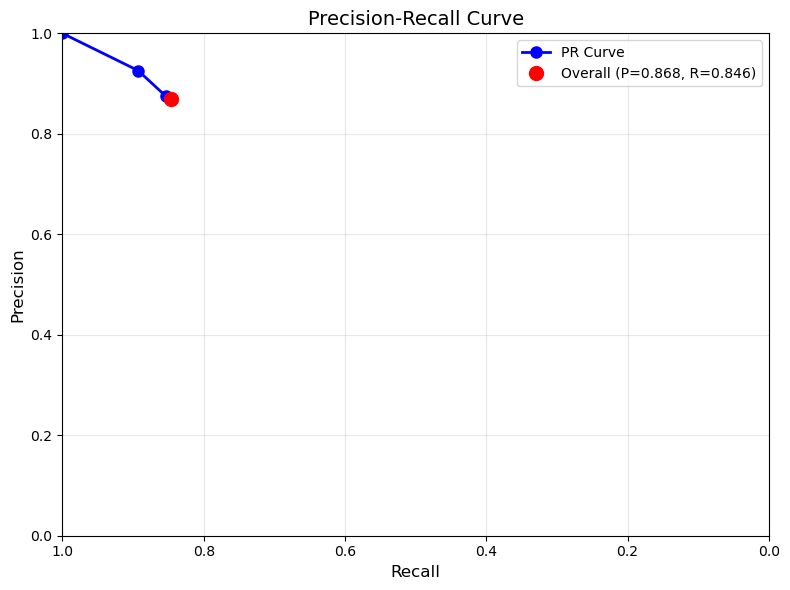

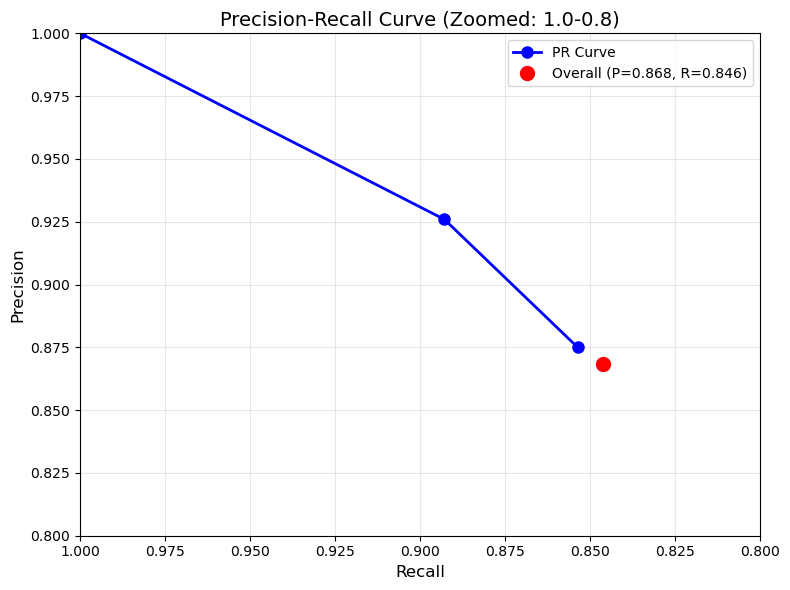

Simple PR Curve:
Overall Precision: 0.868
Overall Recall: 0.846
Overall F1: 0.857


In [92]:
# Simple Precision-Recall Curve (x-axis from 1 to 0)
plt.figure(figsize=(8, 6))

# Plot the simple PR curve (x-axis from 1 to 0)
plt.plot(recalls, precisions, 'bo-', linewidth=2, markersize=8, label='PR Curve')

# Add the overall point
plt.plot(overall_recall, overall_precision, 'ro', markersize=10, 
         label=f'Overall (P={overall_precision:.3f}, R={overall_recall:.3f})')

# No random classifier line

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1, 0)  # x-axis from 1 to 0
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Zoomed view for high precision region (1.0 to 0.8)
plt.figure(figsize=(8, 6))

# Plot the zoomed PR curve
plt.plot(recalls, precisions, 'bo-', linewidth=2, markersize=8, label='PR Curve')

# Add the overall point
plt.plot(overall_recall, overall_precision, 'ro', markersize=10, 
         label=f'Overall (P={overall_precision:.3f}, R={overall_recall:.3f})')

# No random classifier line

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve (Zoomed: 1.0-0.8)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1, 0.8)  # Zoom to high precision region
plt.ylim(0.8, 1)  # Zoom to high precision region

plt.tight_layout()
plt.show()

print(f"Simple PR Curve:")
print(f"Overall Precision: {overall_precision:.3f}")
print(f"Overall Recall: {overall_recall:.3f}")
print(f"Overall F1: {overall_f1:.3f}")


In [164]:
# Robustness Testing for MMSA Algorithm
import random
import numpy as np
from collections import Counter

def calculate_precision_recall_simple(predicted_set, ground_truth_set):
    """Calculate precision and recall for two sets"""
    predicted_tuples = set(predicted_set)
    ground_truth_tuples = set(ground_truth_set)
    
    tp = len(predicted_tuples.intersection(ground_truth_tuples))
    fp = len(predicted_tuples - ground_truth_tuples)
    fn = len(ground_truth_tuples - predicted_tuples)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

def convert_peak_sets_to_mz_based(peak_sets, spec_dic, tolerance=0.01):
    """Convert peak sets from (scan, peak_idx) to (scan, mz) for robust comparison"""
    mz_based_sets = []
    
    for peak_set in peak_sets:
        mz_set = set()
        for scan, peak_idx in peak_set:
            if scan in spec_dic and peak_idx < len(spec_dic[scan].mz):
                mz_value = spec_dic[scan].mz[peak_idx]
                # Simple rounding to 3 decimal places for consistency
                mz_set.add((scan, round(mz_value, 3)))
        mz_based_sets.append(mz_set)
    
    return mz_based_sets

def calculate_precision_recall_with_tolerance(predicted_set, ground_truth_set, tolerance=0.01):
    """Calculate precision and recall with m/z tolerance matching"""
    predicted_tuples = set(predicted_set)
    ground_truth_tuples = set(ground_truth_set)
    
    # For each predicted peak, find matching ground truth peaks within tolerance
    tp = 0
    matched_gt = set()
    
    for pred_scan, pred_mz in predicted_tuples:
        for gt_scan, gt_mz in ground_truth_tuples:
            if pred_scan == gt_scan and abs(pred_mz - gt_mz) <= tolerance:
                tp += 1
                matched_gt.add((gt_scan, gt_mz))
                break
    
    fp = len(predicted_tuples) - tp
    fn = len(ground_truth_tuples) - len(matched_gt)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

def calculate_simple_precision_recall(predicted_sets, ground_truth_sets, tolerance=0.01):
    """Calculate precision/recall by combining all sets and comparing directly"""
    if len(predicted_sets) == 0 or len(ground_truth_sets) == 0:
        return 0.0, 0.0, 0.0
    
    # Combine all predicted sets into one big set
    all_predicted = set()
    for pred_set in predicted_sets:
        all_predicted.update(pred_set)
    
    # Combine all ground truth sets into one big set  
    all_ground_truth = set()
    for gt_set in ground_truth_sets:
        all_ground_truth.update(gt_set)
    
    print(f"    Debug - Total predicted: {len(all_predicted)} peaks")
    print(f"    Debug - Total ground truth: {len(all_ground_truth)} peaks")
    
    # Count true positives with tolerance matching
    tp = 0
    matched_gt = set()
    
    for pred_scan, pred_mz in all_predicted:
        for gt_scan, gt_mz in all_ground_truth:
            if pred_scan == gt_scan and abs(pred_mz - gt_mz) <= tolerance:
                tp += 1
                matched_gt.add((gt_scan, gt_mz))
                break
    
    fp = len(all_predicted) - tp
    fn = len(all_ground_truth) - len(matched_gt)
    
    print(f"    Debug - TP={tp}, FP={fp}, FN={fn}")
    
    # Calculate precision/recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

def run_alignment_with_modified_spectra(modified_spec_dic, df_comp, scans):
    """Run alignment with modified spectra"""
    try:
        # Run alignment
        topo_path, alignments = get_topo_path(modified_spec_dic, df_comp, scans)
        transitive_sets = get_sets(topo_path, alignments)
        new_pairs = new_matches(topo_path, modified_spec_dic)
        peak_sets = add_pairs(transitive_sets, new_pairs)
        
        # Get largest sets (excluding scan 3779)
        largest_sets = sorted(peak_sets, key=len, reverse=True)[:3]
        largest_sets = [[(scan, peak_idx) for scan, peak_idx in s if scan != 3779] for s in largest_sets]
        
        return largest_sets
    except Exception as e:
        print(f"Error in alignment: {e}")
        return [[], [], []]

# Get raw data first (before any filtering)
print("=== GETTING RAW DATA FOR ROBUSTNESS TESTING ===")
print("Fetching raw spectra data before applying custom filters...")

# Import SpectrumTuple if not already imported
try:
    from modifinder.utilities.spectrum_tuple import SpectrumTuple
except ImportError:
    try:
        from modifinder.utilities import SpectrumTuple
    except ImportError:
        # If SpectrumTuple is not available, we'll need to define it or use an alternative
        print("Warning: SpectrumTuple not found. Trying to use existing spectrum format...")

# Get raw spectra using network.get_data method (including scan 3779)
all_scans = [5930, 6052, 6269, 6806, 6812, 6878, 6898, 6900, 8214, 8367, 8372, 8377, 8395, 3779]
print(f"Fetching raw data for {len(all_scans)} scans including 3779...")

raw_spec_dic = {}
for scan in all_scans:
    try:
        usi = f'mzspec:GNPS2:TASK-{TASK_ID}-nf_output/clustering/specs_ms.mgf:scan:{scan}'
        raw_spectrum = network.get_data(usi)
        if raw_spectrum:
            # Convert from network.get_data format to SpectrumTuple format
            # The format has 'peaks' which is a list of [mz, intensity] pairs
            peaks = raw_spectrum['peaks']
            mz_array = [peak[0] for peak in peaks]
            intensity_array = [peak[1] for peak in peaks]
            precursor_value = float(raw_spectrum['precursor_mz'])
            charge = int(raw_spectrum['precursor_charge'])
            
            # Apply MMSA preprocessing: square root + L2 normalization
            import math
            import numpy as np
            
            # Apply square root transformation
            sqrt_intensity = [math.sqrt(x) for x in intensity_array]
            
            # Apply L2 normalization
            l2_norm = math.sqrt(sum(x*x for x in sqrt_intensity))
            normalized_intensity = [x/l2_norm for x in sqrt_intensity]
            
            # Create SpectrumTuple with preprocessed data
            try:
                raw_spec_dic[scan] = SpectrumTuple(scan, precursor_value, charge, mz_array, normalized_intensity)
                print(f"  Successfully fetched scan {scan} ({len(mz_array)} peaks) - with sqrt+L2 preprocessing")
            except NameError:
                # If SpectrumTuple is not available, create a simple object with the same attributes
                class SimpleSpectrum:
                    def __init__(self, scan, precursor_mz, precursor_charge, mz, intensity):
                        self.scan = scan
                        self.precursor_mz = precursor_mz
                        self.precursor_charge = precursor_charge
                        self.mz = mz
                        self.intensity = intensity
                
                raw_spec_dic[scan] = SimpleSpectrum(scan, precursor_value, charge, mz_array, normalized_intensity)
                print(f"  Successfully fetched scan {scan} ({len(mz_array)} peaks) - using SimpleSpectrum with preprocessing")
        else:
            print(f"  Failed to fetch scan {scan}")
    except Exception as e:
        print(f"  Error fetching scan {scan}: {e}")
        print(f"    Error details: {str(e)}")

print(f"\nRaw spectra for testing: {len(raw_spec_dic)} (including scan 3779 for alignment)")
print("Note: This is truly raw data without any peak filtering or normalization")
print()

print("=== ROBUSTNESS TESTING FOR MMSA ALGORITHM ===")
print(f"Task: {TASK_ID}, Component: {COMPONENT}")
print(f"Using raw data: {len(raw_spec_dic)} spectra")
print()


=== GETTING RAW DATA FOR ROBUSTNESS TESTING ===
Fetching raw spectra data before applying custom filters...
Fetching raw data for 14 scans including 3779...
  Successfully fetched scan 5930 (21 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6052 (27 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6269 (30 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6806 (31 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6812 (26 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6878 (28 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6898 (26 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 6900 (35 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 8214 (42 peaks) - using SimpleSpectrum with preprocessing
  Successfully fetched scan 8367 (36 peaks) - using SimpleSpectrum wi

In [172]:
# Experiment 1: Random Noise Simulation
print("=== EXPERIMENT 1: RANDOM NOISE SIMULATION ===")
print("For each spectrum, independently remove each peak with probability p (p is removal rate)")

def random_noise_simulation(spec_dic, p):
    """Simulate random noise by removing each peak with probability p (p is removal rate)"""
    modified_spec_dic = {}
    
    for scan, spectrum in spec_dic.items():
        # Include all scans for alignment, including scan 3779
        mz_array = spectrum.mz
        intensity_array = spectrum.intensity
        
        # Randomly remove peaks with probability p (p is removal rate)
        kept_indices = []
        for i in range(len(mz_array)):
            if random.random() > p:  # Keep peak with probability (1-p)
                kept_indices.append(i)
        
        if len(kept_indices) == 0:
            # If no peaks kept, keep the highest intensity peak
            max_idx = np.argmax(intensity_array)
            kept_indices = [max_idx]
        
        # Create modified spectrum
        kept_mz = [mz_array[i] for i in kept_indices]
        kept_intensity = [intensity_array[i] for i in kept_indices]
        
        modified_spec_dic[scan] = type(spectrum)(
            scan=spectrum.scan,
            precursor_mz=spectrum.precursor_mz,
            precursor_charge=spectrum.precursor_charge,
            mz=kept_mz,
            intensity=kept_intensity
        )
    
    return modified_spec_dic

# Test different noise levels
noise_levels = [0.1, 0.2, 0.3]
baseline_precision = overall_precision
baseline_recall = overall_recall

print(f"Baseline Performance: P={baseline_precision:.3f}, R={baseline_recall:.3f}")
print()

for p in noise_levels:
    print(f"Testing removal rate p={p} (keeping {1-p:.1f} of peaks)...")
    
    # Run multiple trials for statistical significance
    trials = 3
    precisions = []
    recalls = []
    
    for trial in range(trials):
        # Set random seed for reproducibility
        random.seed(42 + trial)
        np.random.seed(42 + trial)
        
        # Apply noise simulation
        modified_spec_dic = random_noise_simulation(filtered_spec_dic, p)
        
        # Run alignment (use all scans including 3779)
        all_scans = list(raw_spec_dic.keys())
        modified_largest_sets = run_alignment_with_modified_spectra(modified_spec_dic, df_comp, all_scans)
        
        if len(modified_largest_sets) >= 3:
            # Convert to m/z-based comparison to handle peak index changes
            modified_mz_sets = convert_peak_sets_to_mz_based(modified_largest_sets, modified_spec_dic)
            ground_truth_mz_sets = convert_peak_sets_to_mz_based([ground_truth_blue, ground_truth_green, ground_truth_red], filtered_spec_dic)
            
            # Combine all predicted sets
            all_predicted = modified_mz_sets[0] | modified_mz_sets[1] | modified_mz_sets[2]
            all_ground_truth = ground_truth_mz_sets[0] | ground_truth_mz_sets[1] | ground_truth_mz_sets[2]
            
            # Calculate precision and recall with tolerance
            precision, recall, f1 = calculate_precision_recall_with_tolerance(all_predicted, all_ground_truth, tolerance=0.01)
            precisions.append(precision)
            recalls.append(recall)
    
    # Calculate average performance
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    
    print(f"  Average Performance: P={avg_precision:.3f}, R={avg_recall:.3f}")
    print(f"  Precision Drop: {baseline_precision - avg_precision:.3f}")
    print(f"  Recall Drop: {baseline_recall - avg_recall:.3f}")
    print()

print("Experiment 1 Complete!")
print()


=== EXPERIMENT 1: RANDOM NOISE SIMULATION ===
For each spectrum, independently remove each peak with probability p (p is removal rate)
Baseline Performance: P=0.868, R=0.846

Testing removal rate p=0.1 (keeping 0.9 of peaks)...
[3779, 6878, 6052, 6806, 8214, 5930, 6898, 8367, 8372, 8377, 6812, 6900, 8395, 6269]
[3779, 6878, 6052, 6806, 8214, 6812, 5930, 6898, 8367, 8377, 8372, 6269, 6900, 8395]
[3779, 6052, 6806, 8214, 6812, 6878, 5930, 8377, 6269, 8372, 6900, 8395, 6898, 8367]
  Average Performance: P=0.343, R=0.316
  Precision Drop: 0.526
  Recall Drop: 0.530

Testing removal rate p=0.2 (keeping 0.8 of peaks)...
[3779, 6052, 6806, 8214, 6812, 8367, 8377, 6269, 6898, 6900, 5930, 8372, 6878, 8395]
[3779, 6878, 6052, 8377, 6806, 6812, 5930, 6269, 8214, 6900, 8367, 6898, 8395, 8372]
[3779, 6052, 6878, 6806, 8214, 6812, 8377, 5930, 6269, 8372, 6900, 8395, 6898, 8367]
  Average Performance: P=0.234, R=0.205
  Precision Drop: 0.634
  Recall Drop: 0.641

Testing removal rate p=0.3 (keeping 0

In [170]:
# Experiment 2: Low Intensity Peaks Removal
print("=== EXPERIMENT 2: LOW INTENSITY PEAKS REMOVAL ===")
print("Remove lowest-intensity peaks with fraction q")

def filter_low_intensity_peaks(spec_dic, q):
    """Remove lowest-intensity peaks with fraction q"""
    modified_spec_dic = {}
    
    for scan, spectrum in spec_dic.items():
        # Include all scans for alignment, including scan 3779
        mz_array = spectrum.mz
        intensity_array = spectrum.intensity
        
        # Sort peaks by intensity (ascending - lowest first) but keep original order
        peak_indices = list(range(len(mz_array)))
        sorted_by_intensity = sorted(peak_indices, key=lambda i: intensity_array[i])  # No reverse - lowest first
        
        # Calculate number of peaks to remove (lowest intensity peaks)
        num_to_remove = int(len(sorted_by_intensity) * q)
        num_to_remove = min(num_to_remove, len(sorted_by_intensity) - 1)  # Keep at least 1 peak
        
        # Get indices to remove (lowest intensity peaks)
        indices_to_remove = set(sorted_by_intensity[:num_to_remove])
        
        # Keep the peaks after removing the lowest intensity ones (maintain original order)
        kept_indices = [i for i in peak_indices if i not in indices_to_remove]
        
        # Debug output for first spectrum
        if scan == list(spec_dic.keys())[0]:
            print(f"  Debug - Scan {scan}: {len(peak_indices)} peaks, removing {num_to_remove} lowest intensity")
            print(f"  Original intensities: {[intensity_array[i] for i in sorted_by_intensity[:5]]}...")
            print(f"  Kept intensities: {[intensity_array[i] for i in kept_indices[:5]]}...")
            
            # Check if any ground truth peaks are being removed
            if scan in raw_spec_dic:
                gt_peaks = [(s, p) for s, p in ground_truth_blue_set | ground_truth_green_set | ground_truth_red_set if s == scan]
                if gt_peaks:
                    print(f"  Ground truth peaks in this scan: {len(gt_peaks)}")
                    for gt_scan, gt_mz in gt_peaks:
                        # Find the peak index for this m/z
                        for i, mz in enumerate(mz_array):
                            if abs(mz - gt_mz) < 0.01:  # Within tolerance
                                if i in indices_to_remove:
                                    print(f"    WARNING: Ground truth peak {gt_mz} (intensity {intensity_array[i]}) is being REMOVED!")
                                else:
                                    print(f"    Ground truth peak {gt_mz} (intensity {intensity_array[i]}) is KEPT")
                                break
        
        # Create modified spectrum
        kept_mz = [mz_array[i] for i in kept_indices]
        kept_intensity = [intensity_array[i] for i in kept_indices]
        
        modified_spec_dic[scan] = type(spectrum)(
            scan=spectrum.scan,
            precursor_mz=spectrum.precursor_mz,
            precursor_charge=spectrum.precursor_charge,
            mz=kept_mz,
            intensity=kept_intensity
        )
    
    return modified_spec_dic

# Test different removal fractions
removal_fractions = [0.1, 0.2, 0.3]

print(f"Baseline Performance: P={baseline_precision:.3f}, R={baseline_recall:.3f}")
print()

for q in removal_fractions:
    print(f"Testing removal fraction q={q} (removing {q:.1f} of lowest intensity peaks)...")
    
    # Run multiple trials for statistical significance
    trials = 3
    precisions = []
    recalls = []
    
    for trial in range(trials):
        # Set random seed for reproducibility
        random.seed(42 + trial)
        np.random.seed(42 + trial)
        
        # Apply low intensity peak filtering
        modified_spec_dic = filter_low_intensity_peaks(filtered_spec_dic, q)
        
        # Run alignment (use all scans including 3779)
        all_scans = list(raw_spec_dic.keys())
        modified_largest_sets = run_alignment_with_modified_spectra(modified_spec_dic, df_comp, all_scans)
        
        if len(modified_largest_sets) >= 3:
            # Convert to m/z-based comparison to handle peak index changes
            modified_mz_sets = convert_peak_sets_to_mz_based(modified_largest_sets, modified_spec_dic)
            ground_truth_mz_sets = convert_peak_sets_to_mz_based([ground_truth_blue, ground_truth_green, ground_truth_red], filtered_spec_dic)
            
            # Use simple precision/recall evaluation
            precision, recall, f1 = calculate_simple_precision_recall(modified_mz_sets, ground_truth_mz_sets, tolerance=0.01)
            precisions.append(precision)
            recalls.append(recall)
    
    # Calculate average performance
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    
    print(f"  Average Performance: P={avg_precision:.3f}, R={avg_recall:.3f}")
    print(f"  Precision Drop: {baseline_precision - avg_precision:.3f}")
    print(f"  Recall Drop: {baseline_recall - avg_recall:.3f}")
    print()

print("Experiment 2 Complete!")
print()


=== EXPERIMENT 2: LOW INTENSITY PEAKS REMOVAL ===
Remove lowest-intensity peaks with fraction q
Baseline Performance: P=0.868, R=0.846

Testing removal fraction q=0.1 (removing 0.1 of lowest intensity peaks)...
  Debug - Scan 3779: 16 peaks, removing 1 lowest intensity
  Original intensities: [0.05104107573902781, 0.05763319053914613, 0.06021099499413398, 0.067464710049988, 0.09133952912689788]...
  Kept intensities: [0.11392301129320566, 0.05763319053914613, 0.20854484310017318, 0.11553152242757626, 0.09133952912689788]...
[3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]
    Debug - Total predicted: 38 peaks
    Debug - Total ground truth: 39 peaks
    Debug - TP=33, FP=5, FN=6
  Debug - Scan 3779: 16 peaks, removing 1 lowest intensity
  Original intensities: [0.05104107573902781, 0.05763319053914613, 0.06021099499413398, 0.067464710049988, 0.09133952912689788]...
  Kept intensities: [0.11392301129320566, 0.05763319053914613, 0.20854484310017318, 0.

In [171]:
# Experiment 3: Blockwise Dropout
print("=== EXPERIMENT 3: BLOCKWISE DROPOUT ===")
print("Remove peaks from top-b most frequent baseline peaks in random fraction of spectra")

def blockwise_dropout(spec_dic, dropout_fraction, top_b=3):
    """Remove top-b most frequent peaks from random fraction of spectra"""
    modified_spec_dic = {}
    
    # Find top-b most frequent peaks in baseline (excluding scan 3779 for frequency calculation)
    all_peaks = []
    for scan, spectrum in spec_dic.items():
        if scan != 3779:  # Skip scan 3779 for frequency calculation
            for mz in spectrum.mz:
                all_peaks.append(mz)
    
    # Count peak frequencies
    peak_counter = Counter(all_peaks)
    top_peaks = [peak for peak, count in peak_counter.most_common(top_b)]
    
    print(f"  Top {top_b} most frequent peaks: {[f'{p:.3f}' for p in top_peaks]}")
    
    # Randomly select spectra for dropout (excluding scan 3779)
    available_scans = [scan for scan in spec_dic.keys() if scan != 3779]
    num_dropout = int(len(available_scans) * dropout_fraction)
    dropout_scans = random.sample(available_scans, num_dropout)
    
    print(f"  Dropping out {len(dropout_scans)} spectra: {dropout_scans}")
    
    for scan, spectrum in spec_dic.items():
        # Include all scans for alignment, including scan 3779
        mz_array = spectrum.mz
        intensity_array = spectrum.intensity
        
        if scan in dropout_scans:
            # Remove top-b most frequent peaks
            kept_indices = []
            for i, mz in enumerate(mz_array):
                if mz not in top_peaks:
                    kept_indices.append(i)
            
            # If no peaks left, keep the highest intensity peak
            if len(kept_indices) == 0:
                max_idx = np.argmax(intensity_array)
                kept_indices = [max_idx]
        else:
            # Keep all peaks
            kept_indices = list(range(len(mz_array)))
        
        # Create modified spectrum
        kept_mz = [mz_array[i] for i in kept_indices]
        kept_intensity = [intensity_array[i] for i in kept_indices]
        
        modified_spec_dic[scan] = type(spectrum)(
            scan=spectrum.scan,
            precursor_mz=spectrum.precursor_mz,
            precursor_charge=spectrum.precursor_charge,
            mz=kept_mz,
            intensity=kept_intensity
        )
    
    return modified_spec_dic

# Test different dropout fractions
dropout_fractions = [0.1, 0.2, 0.3]

print(f"Baseline Performance: P={baseline_precision:.3f}, R={baseline_recall:.3f}")
print()

for dropout_frac in dropout_fractions:
    print(f"Testing dropout fraction {dropout_frac}...")
    
    # Run multiple trials for statistical significance
    trials = 3
    precisions = []
    recalls = []
    
    for trial in range(trials):
        # Set random seed for reproducibility
        random.seed(42 + trial)
        np.random.seed(42 + trial)
        
        # Apply blockwise dropout
        modified_spec_dic = blockwise_dropout(filtered_spec_dic, dropout_frac)
        
        # Run alignment (use all scans including 3779)
        all_scans = list(raw_spec_dic.keys())
        modified_largest_sets = run_alignment_with_modified_spectra(modified_spec_dic, df_comp, all_scans)
        
        if len(modified_largest_sets) >= 3:
            # Convert to m/z-based comparison to handle peak index changes
            modified_mz_sets = convert_peak_sets_to_mz_based(modified_largest_sets, modified_spec_dic)
            ground_truth_mz_sets = convert_peak_sets_to_mz_based([ground_truth_blue, ground_truth_green, ground_truth_red], filtered_spec_dic)
            
            # Use simple precision/recall evaluation
            precision, recall, f1 = calculate_simple_precision_recall(modified_mz_sets, ground_truth_mz_sets, tolerance=0.01)
            precisions.append(precision)
            recalls.append(recall)
    
    # Calculate average performance
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    
    print(f"  Average Performance: P={avg_precision:.3f}, R={avg_recall:.3f}")
    print(f"  Precision Drop: {baseline_precision - avg_precision:.3f}")
    print(f"  Recall Drop: {baseline_recall - avg_recall:.3f}")
    print()

print("Experiment 3 Complete!")
print()


=== EXPERIMENT 3: BLOCKWISE DROPOUT ===
Remove peaks from top-b most frequent baseline peaks in random fraction of spectra
Baseline Performance: P=0.868, R=0.846

Testing dropout fraction 0.1...
  Top 3 most frequent peaks: ['169.047', '357.189', '315.105']
  Dropping out 1 spectra: [8372]
[3779, 6878, 6052, 6806, 8214, 6812, 8395, 8367, 8377, 5930, 6269, 6900, 8372, 6898]
    Debug - Total predicted: 39 peaks
    Debug - Total ground truth: 39 peaks
    Debug - TP=16, FP=23, FN=23
  Top 3 most frequent peaks: ['169.047', '357.189', '315.105']
  Dropping out 1 spectra: [8395]
[3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]
    Debug - Total predicted: 38 peaks
    Debug - Total ground truth: 39 peaks
    Debug - TP=33, FP=5, FN=6
  Top 3 most frequent peaks: ['169.047', '357.189', '315.105']
  Dropping out 1 spectra: [5930]
[3779, 6878, 6052, 6806, 8214, 5930, 6812, 8367, 8372, 8377, 6269, 6900, 8395, 6898]
    Debug - Total predicted: 36 peaks
    

In [173]:
network.get_data('mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-input_spectra/MPAO1-3_P2-B-6_01_11809.mzXML:scan:78')

{'n_peaks': 9,
 'peaks': [[61.01079559326172, 326.0],
  [74.02046203613281, 140.0],
  [77.00061798095703, 108.0],
  [78.92308807373047, 108.0],
  [84.08003234863281, 220.0],
  [84.96129608154297, 184.0],
  [105.04550170898438, 98.0],
  [118.92658233642578, 130.0],
  [544.1992797851562, 254.0]],
 'precursor_charge': 0,
 'precursor_mz': 150.05851746,
 'splash': 'splash10-01sl-9100020000-ba6a19f04f1014fbab03',
 'usi': 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-input_spectra/MPAO1-3_P2-B-6_01_11809.mzXML:scan:78',
 'id': 'mzspec:GNPS2:TASK-44e5488732e44a8599788ca2001896f6-input_spectra/MPAO1-3_P2-B-6_01_11809.mzXML:scan:78'}

In [201]:
# === Phantom peaks quantification for consensus spectra ===

from typing import Dict, Any, List, Tuple, Iterable, Optional
import math
import bisect
import csv
import json
import pandas as pd

# ---------- helpers ----------

def ppm_err(mz_a: float, mz_b: float) -> float:
    return abs(mz_a - mz_b) / max(mz_b, 1e-9) * 1e6

def percentile(values: List[float], q: float) -> float:
    """q in [0,100] ; simple percentile without numpy"""
    if not values:
        return float("nan")
    xs = sorted(values)
    if len(xs) == 1:
        return xs[0]
    k = (len(xs) - 1) * (q / 100.0)
    f = math.floor(k); c = math.ceil(k)
    if f == c:
        return xs[int(k)]
    return xs[f] * (c - k) + xs[c] * (k - f)

def make_consensus_usi(task_id: str, consensus_scan: int) -> str:
    return f"mzspec:GNPS2:TASK-{task_id}-nf_output/clustering/specs_ms.mgf:scan:{consensus_scan}"

def make_raw_usi(task_id: str, filename: str, scan: int) -> str:
    return f"mzspec:GNPS2:TASK-{task_id}-{filename}:scan:{scan}"

def load_clusterinfo(path: str) -> pd.DataFrame:
    """
    TSV must have columns: clusteridx, Filename, scan
    where clusteridx == consensus scan number (per your note).
    """
    df = pd.read_csv(path, sep="\t", dtype=str)
    df["#ClusterIdx"] = pd.to_numeric(df["#ClusterIdx"], errors="coerce").astype("Int64")
    df["#Scan"]       = pd.to_numeric(df["#Scan"], errors="coerce").astype("Int64")
    return df

def build_cluster_map(df: pd.DataFrame) -> Dict[int, List[Tuple[str,int]]]:
    mp: Dict[int, List[Tuple[str,int]]] = {}
    for _, r in df.iterrows():
        cidx = int(r["#ClusterIdx"])
        fn   = str(r["#Filename"])
        sc   = int(r["#Scan"])
        mp.setdefault(cidx, []).append((fn, sc))
    return mp

# ---------- core: compute per-peak support for one consensus spectrum ----------

def _has_hit_in_member(peaks_sorted: List[Tuple[float, float]],
                       mz: float, ppm_tol: float) -> Tuple[bool, float]:
    """Check if member spectrum has >=1 peak within ppm_tol around mz. Returns (hit, best_ppm)."""
    if not peaks_sorted:
        return (False, float("nan"))
    mz_lower = mz * (1 - ppm_tol / 1e6)
    mz_upper = mz * (1 + ppm_tol / 1e6)
    idx = bisect.bisect_left(peaks_sorted, (mz_lower, -float("inf")))
    best_ppm = float("inf"); hit = False
    n = len(peaks_sorted)
    while idx < n and peaks_sorted[idx][0] <= mz_upper:
        ppm = ppm_err(peaks_sorted[idx][0], mz)
        if ppm <= ppm_tol:
            hit = True
            if ppm < best_ppm:
                best_ppm = ppm
        idx += 1
    return (hit, best_ppm if hit else float("nan"))

def detect_phantoms_for_consensus(
    consensus_spec: Dict[str, Any],
    member_specs: List[Dict[str, Any]],
    ppm_tol: float = 10.0,
    intensity_threshold: float = 0.0,
) -> Dict[str, Any]:
    """
    For each peak in the consensus spectrum, count how many member raw spectra
    contain a peak within ppm_tol and above intensity_threshold.
    Returns per-peak records with support_count, support_fraction, and ppm_iqr.
    """
    cons_peaks = consensus_spec.get("peaks", [])
    N = max(len(member_specs), 1)

    # preprocess members: filter-by-intensity and sort by m/z
    members: List[List[Tuple[float, float]]] = []
    for ms in member_specs:
        pp = [(float(m), float(I)) for m, I in ms.get("peaks", []) if float(I) >= intensity_threshold]
        pp.sort(key=lambda x: x[0])
        members.append(pp)

    out = {"n_members": N, "peaks": []}
    for mz, I in cons_peaks:
        mz = float(mz); I = float(I)
        s = 0
        ppm_hits: List[float] = []
        for peaks_sorted in members:
            hit, ppmv = _has_hit_in_member(peaks_sorted, mz, ppm_tol)
            if hit:
                s += 1
                if math.isfinite(ppmv):
                    ppm_hits.append(ppmv)
        supp_frac = s / N if N > 0 else 0.0
        ppm_iqr = float("nan")
        if len(ppm_hits) >= 4:
            q1 = percentile(ppm_hits, 25)
            q3 = percentile(ppm_hits, 75)
            ppm_iqr = q3 - q1
        out["peaks"].append({
            "mz": mz,
            "consensus_intensity": I,
            "support_count": int(s),
            "support_fraction": supp_frac,
            "ppm_iqr": ppm_iqr,
        })
    return out

# ---------- orchestrator over many consensus scans ----------

def quantify_phantoms_for_consensus_scans(
    clusterinfo_tsv: str,
    task_id: str,
    consensus_scans: Iterable[int],
    get_spectrum,                      # your network.get_data
    ppm_tol: float = 10.0,
    intensity_threshold: float = 0.0,
    tau_f: float = 0.1,                # label phantom if support_fraction < tau_f
    use_ppm_iqr: bool = False,         # if True, also require ppm_iqr > ppm_iqr_thresh
    ppm_iqr_thresh: float = 3.0,
    save_csv: Optional[str] = None,
    save_json: Optional[str] = None,
) -> Dict[int, Dict[str, Any]]:
    df = load_clusterinfo(clusterinfo_tsv)
    cmap = build_cluster_map(df)

    results: Dict[int, Dict[str, Any]] = {}
    for cscan in consensus_scans:
        cons_usi = make_consensus_usi(task_id, int(cscan))
        member_pairs = cmap.get(int(cscan), [])
        member_usis = [make_raw_usi(task_id, fn, sc) for (fn, sc) in member_pairs]

        cons_spec = get_spectrum(cons_usi)
        member_specs = [get_spectrum(u) for u in member_usis]

        detail = detect_phantoms_for_consensus(
            cons_spec, member_specs, ppm_tol=ppm_tol, intensity_threshold=intensity_threshold
        )

        peaks_out = []
        phantom_count = 0
        for rec in detail["peaks"]:
            is_phantom = (rec["support_fraction"] < tau_f)
            if use_ppm_iqr and math.isfinite(rec["ppm_iqr"]):
                is_phantom = is_phantom and (rec["ppm_iqr"] > ppm_iqr_thresh)
            rec2 = dict(rec); rec2["phantom"] = bool(is_phantom)
            peaks_out.append(rec2)
            if rec2["phantom"]:
                phantom_count += 1

        results[int(cscan)] = {
            "consensus_usi": cons_usi,
            "n_members": int(detail["n_members"]),
            "phantom_fraction": (phantom_count / max(len(peaks_out), 1)),
            "peaks": peaks_out,
        }

    if save_json:
        with open(save_json, "w") as f:
            json.dump(results, f, indent=2)
    if save_csv:
        with open(save_csv, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["consensus_scan","consensus_usi","n_members","mz","consensus_intensity",
                        "support_count","support_fraction","ppm_iqr","phantom"])
            for cscan, data in results.items():
                for rec in data["peaks"]:
                    w.writerow([
                        cscan, data["consensus_usi"], data["n_members"],
                        f'{rec["mz"]:.6f}', f'{rec["consensus_intensity"]:.6g}',
                        rec["support_count"], f'{rec["support_fraction"]:.4f}',
                        (f'{rec["ppm_iqr"]:.3f}' if math.isfinite(rec["ppm_iqr"]) else ""),
                        int(rec["phantom"])
                    ])
    return results

In [245]:
TASK_ID = "44e5488732e44a8599788ca2001896f6"
CLUSTERINFO_TSV = "44e5488732e44a8599788ca2001896f6-clusterinfo.tsv"
CONS_SCANS = [3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]

def get_spectrum(usi):
    time.sleep(0.5)
    return network.get_data(usi)

results = quantify_phantoms_for_consensus_scans(
    CLUSTERINFO_TSV, TASK_ID, CONS_SCANS, get_spectrum,
    ppm_tol=200.0, intensity_threshold=0.0, tau_f=0.1,
    use_ppm_iqr=False,
    save_csv="phantoms_detail.csv",
    save_json="phantoms_detail.json",
)
print("Done. Keys:", list(results.keys()))

Done. Keys: [3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]


consensus_scan  phantom_fraction  n_phantom  n_peaks  n_members  \
0             6806          0.354839         11       31         30   
1             8372          0.317073         13       41         31   
2             6052          0.296296          8       27         53   
3             6878          0.285714          8       28         21   
4             8377          0.263158         10       38         11   
5             8214          0.238095         10       42         39   
6             5930          0.238095          5       21         22   
7             8395          0.216216          8       37         16   
8             6812          0.192308          5       26         47   
9             8367          0.111111          4       36         18   
10            6898          0.038462          1       26          9   
11            6269          0.033333          1       30          8   
12            3779          0.000000          0       16          8   
13            6900          0.000000          0       35          9   

                                   phantom_mzs_sample  
0   91.018997, 107.003998, 494.359985, 529.656006,...  
1   123.036003, 475.239990, 620.802002, 645.349976...  
2   62.980000, 64.975998, 81.038002, 85.049004, 10...  
3   57.071999, 85.030998, 336.989990, 474.550995, ...  
4   64.978996, 69.045998, 85.063004, 123.071999, 2...  
5   64.974998, 66.155998, 257.001007, 587.325989, ...  
6   82.944000, 125.000999, 297.244995, 429.197998,...  
7   64.977997, 78.734001, 129.018005, 653.880981, ...  
8   71.049004, 283.049011, 473.351013, 485.169006,...  
9       66.977997, 625.416992, 639.320007, 780.497009  
10                                         107.992996  
11                                         283.183990  
12                                                     
13

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


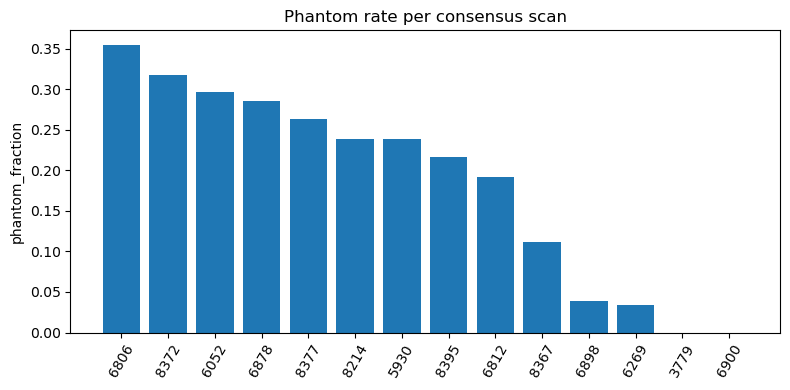

mz  consensus_intensity  support_count  support_fraction  ppm_iqr  \
0  107.992996            74.275002              0               0.0      NaN   

   phantom  
0     True

In [246]:
def summarize_results(results: dict) -> pd.DataFrame:
    rows = []
    for cscan, data in results.items():
        peaks = data.get("peaks", [])
        n_peaks = len(peaks)
        n_phantom = sum(1 for r in peaks if r.get("phantom", False))
        rows.append({
            "consensus_scan": int(cscan),
            "consensus_usi": data.get("consensus_usi", ""),
            "n_members": data.get("n_members", None),
            "n_peaks": n_peaks,
            "n_phantom": n_phantom,
            "phantom_fraction": (n_phantom / n_peaks) if n_peaks else 0.0,
            "phantom_mzs_sample": ", ".join([f'{r["mz"]:.6f}' for r in peaks if r.get("phantom", False)][:10]),
        })
    df = pd.DataFrame(rows)
    return df.sort_values("phantom_fraction", ascending=False, ignore_index=True)

summary_df = summarize_results(results)
display(summary_df[["consensus_scan","phantom_fraction","n_phantom","n_peaks","n_members","phantom_mzs_sample"]])


plt.figure(figsize=(8,4))
x = summary_df["consensus_scan"].astype(str)
y = summary_df["phantom_fraction"]
plt.bar(x, y)
plt.xticks(rotation=60)
plt.ylabel("phantom_fraction")
plt.title("Phantom rate per consensus scan")
plt.tight_layout()
plt.show()

def show_consensus_details(results: dict, cscan: int, only_phantom: bool=True, topn: int=30):
    data = results[int(cscan)]
    rows = []
    for r in data["peaks"]:
        if only_phantom and not r["phantom"]:
            continue
        rows.append({
            "mz": r["mz"],
            "consensus_intensity": r["consensus_intensity"],
            "support_count": r["support_count"],
            "support_fraction": r["support_fraction"],
            "ppm_iqr": r["ppm_iqr"],
            "phantom": r["phantom"],
        })
    df = pd.DataFrame(rows).sort_values(["phantom","support_fraction","mz"], ascending=[False, True, True])
    return df.head(topn)


details_6898 = show_consensus_details(results, 6898, only_phantom=True, topn=50)
display(details_6898)

In [247]:
# === Phantom Peak Removal and Re-alignment ===

import json
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Any

def load_phantom_analysis_results(json_path: str) -> Dict[int, Dict[str, Any]]:
    """Load phantom analysis results from JSON file"""
    with open(json_path, 'r') as f:
        return json.load(f)

def remove_phantom_peaks_from_spectrum(spectrum_data: Dict[str, Any], 
                                     phantom_peaks: List[Dict[str, Any]], 
                                     ppm_tolerance: float = 10.0) -> Dict[str, Any]:
    """
    Remove phantom peaks from a spectrum based on phantom analysis results
    
    Args:
        spectrum_data: Spectrum data with 'peaks' field containing [mz, intensity] pairs
        phantom_peaks: List of phantom peak records with 'mz' and 'phantom' fields
        ppm_tolerance: PPM tolerance for matching peaks
    
    Returns:
        Modified spectrum data with phantom peaks removed
    """
    if 'peaks' not in spectrum_data:
        return spectrum_data
    
    original_peaks = spectrum_data['peaks']
    filtered_peaks = []
    
    # Create a set of phantom m/z values for quick lookup
    phantom_mz_values = set()
    for phantom_peak in phantom_peaks:
        if phantom_peak.get('phantom', False):
            phantom_mz_values.add(phantom_peak['mz'])
    
    # Filter out phantom peaks
    for mz, intensity in original_peaks:
        is_phantom = False
        
        # Check if this peak matches any phantom peak within ppm tolerance
        for phantom_mz in phantom_mz_values:
            ppm_error = abs(mz - phantom_mz) / max(phantom_mz, 1e-9) * 1e6
            if ppm_error <= ppm_tolerance:
                is_phantom = True
                break
        
        if not is_phantom:
            filtered_peaks.append([mz, intensity])
    
    # Create modified spectrum data
    modified_spectrum = spectrum_data.copy()
    modified_spectrum['peaks'] = filtered_peaks
    
    return modified_spectrum

def remove_phantom_peaks_from_spec_dic(spec_dic: Dict[int, Any], 
                                      phantom_results: Dict[int, Dict[str, Any]], 
                                      ppm_tolerance: float = 10.0) -> Dict[int, Any]:
    """
    Remove phantom peaks from all spectra in spec_dic based on phantom analysis
    
    Args:
        spec_dic: Dictionary mapping scan numbers to spectrum data
        phantom_results: Phantom analysis results from quantify_phantoms_for_consensus_scans
        ppm_tolerance: PPM tolerance for matching peaks
    
    Returns:
        Modified spec_dic with phantom peaks removed
    """
    modified_spec_dic = {}
    
    for scan, spectrum_data in spec_dic.items():
        # Check if this scan has phantom analysis results
        if str(scan) in phantom_results:
            phantom_peaks = phantom_results[str(scan)].get('peaks', [])
            modified_spectrum = remove_phantom_peaks_from_spectrum(
                spectrum_data, phantom_peaks, ppm_tolerance
            )
            modified_spec_dic[scan] = modified_spectrum
            print(f"Scan {scan}: Removed {len(spectrum_data['peaks']) - len(modified_spectrum['peaks'])} phantom peaks")
        else:
            # No phantom analysis for this scan, keep original
            modified_spec_dic[scan] = spectrum_data
            print(f"Scan {scan}: No phantom analysis available, keeping original")
    
    return modified_spec_dic

# Load phantom analysis results
print("=== LOADING PHANTOM ANALYSIS RESULTS ===")
phantom_results = load_phantom_analysis_results("phantoms_detail.json")
print(f"Loaded phantom analysis for {len(phantom_results)} consensus scans")

# Show summary of phantom peaks per scan
for scan, data in phantom_results.items():
    n_phantom = sum(1 for peak in data['peaks'] if peak.get('phantom', False))
    n_total = len(data['peaks'])
    print(f"Scan {scan}: {n_phantom}/{n_total} peaks are phantom ({n_phantom/n_total*100:.1f}%)")


=== LOADING PHANTOM ANALYSIS RESULTS ===
Loaded phantom analysis for 14 consensus scans
Scan 3779: 0/16 peaks are phantom (0.0%)
Scan 6878: 8/28 peaks are phantom (28.6%)
Scan 6052: 8/27 peaks are phantom (29.6%)
Scan 6806: 11/31 peaks are phantom (35.5%)
Scan 8214: 10/42 peaks are phantom (23.8%)
Scan 6812: 5/26 peaks are phantom (19.2%)
Scan 8367: 4/36 peaks are phantom (11.1%)
Scan 8372: 13/41 peaks are phantom (31.7%)
Scan 8377: 10/38 peaks are phantom (26.3%)
Scan 5930: 5/21 peaks are phantom (23.8%)
Scan 6269: 1/30 peaks are phantom (3.3%)
Scan 6900: 0/35 peaks are phantom (0.0%)
Scan 8395: 8/37 peaks are phantom (21.6%)
Scan 6898: 1/26 peaks are phantom (3.8%)


In [241]:


# Convert filtered_spec_dic to the format expected by phantom removal
# The phantom removal expects spectra with 'peaks' field containing [mz, intensity] pairs
converted_spec_dic = {}
for scan, spec in filtered_spec_dic.items():
    if hasattr(spec, 'mz') and hasattr(spec, 'intensity'):
        # Convert SpectrumTuple to dict format
        peaks = [[mz, intensity] for mz, intensity in zip(spec.mz, spec.intensity)]
        converted_spec_dic[scan] = {
            'peaks': peaks,
            'precursor_mz': getattr(spec, 'precursor_mz', 0),
            'precursor_charge': getattr(spec, 'precursor_charge', 0)
        }
    elif isinstance(spec, dict) and 'peaks' in spec:
        # Already in the right format
        converted_spec_dic[scan] = spec
    else:
        print(f"Warning: Unknown spectrum format for scan {scan}")
        converted_spec_dic[scan] = spec

print(f"Converted {len(converted_spec_dic)} spectra to phantom removal format")


Converted 14 spectra to phantom removal format


In [248]:
# === Apply Phantom Peak Removal ===

print("=== APPLYING PHANTOM PEAK REMOVAL ===")

# Apply phantom peak removal to the converted spec dic
modified_spec_dic = remove_phantom_peaks_from_spec_dic(
    converted_spec_dic, 
    phantom_results, 
    ppm_tolerance=10.0
)

print(f"\n=== PHANTOM REMOVAL SUMMARY ===")
total_original_peaks = sum(len(spec['peaks']) for spec in converted_spec_dic.values())
total_modified_peaks = sum(len(spec['peaks']) for spec in modified_spec_dic.values())
total_removed = total_original_peaks - total_modified_peaks

print(f"Total original peaks: {total_original_peaks}")
print(f"Total peaks after phantom removal: {total_modified_peaks}")
print(f"Total phantom peaks removed: {total_removed}")
print(f"Removal rate: {total_removed/total_original_peaks*100:.1f}%")

# Convert back to SpectrumTuple format for alignment
print("\n=== CONVERTING BACK TO SPECTRUMTUPLE FORMAT ===")

# Import SpectrumTuple
try:
    from modifinder.utilities.spectrum_tuple import SpectrumTuple
except ImportError:
    try:
        from modifinder.utilities import SpectrumTuple
    except ImportError:
        # Define a simple SpectrumTuple class if not available
        class SpectrumTuple:
            def __init__(self, scan, precursor_mz, precursor_charge, mz, intensity):
                self.scan = scan
                self.precursor_mz = precursor_mz
                self.precursor_charge = precursor_charge
                self.mz = mz
                self.intensity = intensity

# Convert modified spectra back to SpectrumTuple format
modified_filtered_spec_dic = {}
for scan, spec_data in modified_spec_dic.items():
    if 'peaks' in spec_data:
        peaks = spec_data['peaks']
        mz_array = [peak[0] for peak in peaks]
        intensity_array = [peak[1] for peak in peaks]
        
        modified_filtered_spec_dic[scan] = SpectrumTuple(
            scan=scan,
            precursor_mz=spec_data.get('precursor_mz', 0),
            precursor_charge=spec_data.get('precursor_charge', 0),
            mz=mz_array,
            intensity=intensity_array
        )

print(f"Converted {len(modified_filtered_spec_dic)} modified spectra to SpectrumTuple format")


=== APPLYING PHANTOM PEAK REMOVAL ===
Scan 3779: Removed 0 phantom peaks
Scan 8395: Removed 8 phantom peaks
Scan 6806: Removed 11 phantom peaks
Scan 8214: Removed 10 phantom peaks
Scan 6812: Removed 5 phantom peaks
Scan 6878: Removed 8 phantom peaks
Scan 6052: Removed 8 phantom peaks
Scan 5930: Removed 5 phantom peaks
Scan 8367: Removed 4 phantom peaks
Scan 6898: Removed 1 phantom peaks
Scan 6900: Removed 0 phantom peaks
Scan 8372: Removed 13 phantom peaks
Scan 8377: Removed 10 phantom peaks
Scan 6269: Removed 1 phantom peaks

=== PHANTOM REMOVAL SUMMARY ===
Total original peaks: 432
Total peaks after phantom removal: 348
Total phantom peaks removed: 84
Removal rate: 19.4%

=== CONVERTING BACK TO SPECTRUMTUPLE FORMAT ===
Converted 14 modified spectra to SpectrumTuple format


In [233]:
for scan, spec in modified_filtered_spec_dic.items():
    print(scan, spec.mz, spec.intensity)

3779 [71.049004, 72.081001, 95.085999, 149.029007, 169.048004, 187.057007, 209.130005, 211.130997, 212.134995, 263.016998, 266.084015, 317.184998] [0.11392301129320566, 0.05763319053914613, 0.11553152242757626, 0.09680262408499114, 0.29828084326681276, 0.39860694987710005, 0.12709125032561291, 0.738818381427557, 0.26124855942623554, 0.067464710049988, 0.06021099499413398, 0.05104107573902781]
8395 [90.974998, 135.009003, 158.966003, 169.046997, 174.951004, 200.951004, 226.951996, 239.160995, 240.167007, 315.105011, 316.109009, 333.117004, 378.916992, 385.220001, 391.186005, 437.321014, 438.328003, 439.32901, 444.917999, 503.244995, 527.166992, 531.278015, 532.281006, 583.382019, 584.387024, 589.518005, 591.533997] [0.04896128030826515, 0.18653498002860064, 0.10776410879529272, 0.05428738757064894, 0.09369302218794906, 0.13743874255268837, 0.10681544791422237, 0.20474634962877097, 0.08744005825959385, 0.4207131360129225, 0.1504817934038748, 0.18444614979704207, 0.06870382082245605, 0.12

In [249]:
# === Re-run Alignment with Phantom Peaks Removed ===

print("=== RE-RUNNING ALIGNMENT WITH PHANTOM PEAKS REMOVED ===")
print(scan_numbers)
print(all_scans)

# Run alignment with modified spectra
try:
    topo_path_modified, alignments_modified = get_topo_path(
        modified_filtered_spec_dic, df_comp, scan_numbers
    )
    print("✓ Topological path calculation completed")
    
    transitive_sets_modified = get_sets(topo_path_modified, alignments_modified)
    print("✓ Transitive sets calculation completed")
    
    new_pairs_modified = new_matches(topo_path_modified, modified_filtered_spec_dic)
    print("✓ New matches calculation completed")
    peak_sets_modified = []
    peak_sets_modified = add_pairs(transitive_sets_modified, new_pairs_modified)
    print("✓ Peak sets merging completed")
    
    print(f"\nAlignment completed successfully!")
    print(f"Total peak sets found: {len(peak_sets_modified)}")
    
    # Get largest sets (excluding scan 3779 if present)
    largest_sets_modified = sorted(peak_sets_modified, key=len, reverse=True)[:3]
    largest_sets_modified = [[(scan, peak_idx) for scan, peak_idx in s if scan != 3779] for s in largest_sets_modified]
    
    print(f"Largest 3 sets sizes: {[len(s) for s in largest_sets_modified]}")
    
except Exception as e:
    print(f"Error during alignment: {e}")
    import traceback
    traceback.print_exc()
    peak_sets_modified = []
    largest_sets_modified = [[], [], []]


=== RE-RUNNING ALIGNMENT WITH PHANTOM PEAKS REMOVED ===
{3779, 8395, 6806, 8214, 6812, 6878, 6052, 5930, 8367, 6898, 6900, 8372, 8377, 6269}
[5930, 6052, 6269, 6806, 6812, 6878, 6898, 6900, 8214, 8367, 8372, 8377, 8395, 3779]
[3779, 6878, 6052, 6806, 8214, 6812, 8367, 8372, 8377, 5930, 6269, 6900, 8395, 6898]
✓ Topological path calculation completed
✓ Transitive sets calculation completed
✓ New matches calculation completed
✓ Peak sets merging completed

Alignment completed successfully!
Total peak sets found: 48
Largest 3 sets sizes: [13, 12, 13]


In [250]:
# Convert modified results to m/z-based format for comparison
modified_mz_sets = convert_peak_sets_to_mz_based(largest_sets_modified, modified_filtered_spec_dic)
print(modified_mz_sets)
ground_truth_mz_sets = convert_peak_sets_to_mz_based([ground_truth_blue, ground_truth_green, ground_truth_red], filtered_spec_dic)
print(ground_truth_mz_sets)
# Use the same comparison method as before
precision, recall, f1 = calculate_simple_precision_recall(modified_mz_sets, ground_truth_mz_sets, tolerance=0.1)

print(f"\n=== EVALUATION RESULTS (vs Ground Truth) ===")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
    

[{(5930, 357.189), (8377, 357.119), (6878, 399.199), (6052, 357.188), (6812, 357.189), (6806, 357.189), (6900, 357.186), (8395, 503.245), (8372, 357.189), (6269, 357.187), (6898, 187.059), (8214, 357.189), (8367, 357.187)}, {(6806, 211.13), (6812, 211.13), (6269, 211.13), (8377, 211.106), (6898, 435.305), (8395, 583.382), (6052, 211.13), (8214, 211.131), (6878, 211.1), (8367, 211.131), (8372, 211.131), (5930, 211.131)}, {(6878, 135.007), (8214, 135.005), (6898, 135.002), (6806, 135.003), (8367, 135.003), (5930, 135.004), (8377, 135.013), (8372, 135.002), (6812, 135.011), (8395, 135.009), (6052, 135.017), (6900, 135.004), (6269, 135.003)}]
[{(5930, 357.189), (8377, 357.119), (6878, 399.199), (6806, 357.189), (6052, 357.188), (6812, 357.189), (6900, 357.186), (8395, 503.245), (8372, 357.189), (6269, 357.187), (6898, 187.059), (8214, 357.189), (8367, 357.187)}, {(6806, 211.13), (6269, 211.13), (6812, 211.13), (6898, 239.162), (8377, 211.106), (6900, 239.162), (8395, 239.161), (6052, 211.1

In [220]:
# === Check if peak 211.10006 exists in modified_filtered_spec_dic ===

print("=== CHECKING PEAK 211.10006 IN MODIFIED_FILTERED_SPEC_DIC ===")

target_scan = 6878
target_mz = 211.10006

print(f"Checking scan {target_scan} for peak m/z {target_mz}")

# Check if scan exists in modified_filtered_spec_dic
if target_scan in modified_filtered_spec_dic:
    spectrum = modified_filtered_spec_dic[target_scan]
    print(f"✓ Scan {target_scan} found in modified_filtered_spec_dic")
    
    # Get m/z values
    mz_values = spectrum.mz
    print(f"Total peaks in modified spectrum: {len(mz_values)}")
    
    # Check for exact match
    exact_match = target_mz in mz_values
    print(f"Exact match for {target_mz}: {exact_match}")
    
    # Check for close matches within 10 ppm
    close_matches = []
    for i, mz in enumerate(mz_values):
        ppm_error = abs(mz - target_mz) / max(target_mz, 1e-9) * 1e6
        if ppm_error <= 10.0:  # 10 ppm tolerance
            close_matches.append((i, mz, ppm_error))
    
    print(f"Close matches (≤10 ppm): {len(close_matches)}")
    for i, mz, ppm_error in close_matches:
        print(f"  Peak {i}: m/z {mz:.6f} (ppm error: {ppm_error:.2f})")
    
    # Show all m/z values around 211
    mz_around_211 = [(i, mz) for i, mz in enumerate(mz_values) if 210.0 <= mz <= 212.0]
    print(f"\nAll peaks around m/z 211:")
    for i, mz in mz_around_211:
        intensity = spectrum.intensity[i]
        print(f"  Peak {i}: m/z {mz:.6f}, intensity {intensity:.2f}")
    
    # Check if this peak was in the original spectrum
    if target_scan in converted_spec_dic:
        original_peaks = converted_spec_dic[target_scan]['peaks']
        original_mz_values = [peak[0] for peak in original_peaks]
        
        print(f"\nOriginal spectrum had {len(original_mz_values)} peaks")
        original_exact_match = target_mz in original_mz_values
        print(f"Original spectrum had exact match for {target_mz}: {original_exact_match}")
        
        # Check original close matches
        original_close_matches = []
        for i, (mz, intensity) in enumerate(original_peaks):
            ppm_error = abs(mz - target_mz) / max(target_mz, 1e-9) * 1e6
            if ppm_error <= 10.0:
                original_close_matches.append((i, mz, intensity, ppm_error))
        
        print(f"Original close matches (≤10 ppm): {len(original_close_matches)}")
        for i, mz, intensity, ppm_error in original_close_matches:
            print(f"  Peak {i}: m/z {mz:.6f}, intensity {intensity:.2f} (ppm error: {ppm_error:.2f})")
        
        # Check if it was marked as phantom
        if str(target_scan) in phantom_results:
            phantom_peaks = phantom_results[str(target_scan)]['peaks']
            phantom_mz_values = [p['mz'] for p in phantom_peaks if p.get('phantom', False)]
            
            print(f"\nPhantom analysis for scan {target_scan}:")
            print(f"Total phantom peaks: {len(phantom_mz_values)}")
            
            # Check if 211.10006 was marked as phantom
            phantom_matches = []
            for phantom_peak in phantom_peaks:
                if phantom_peak.get('phantom', False):
                    ppm_error = abs(phantom_peak['mz'] - target_mz) / max(target_mz, 1e-9) * 1e6
                    if ppm_error <= 10.0:
                        phantom_matches.append((phantom_peak['mz'], phantom_peak['support_fraction'], ppm_error))
            
            print(f"Phantom peaks near {target_mz}: {len(phantom_matches)}")
            for mz, support, ppm_error in phantom_matches:
                print(f"  Phantom: m/z {mz:.6f}, support {support:.3f} (ppm error: {ppm_error:.2f})")
            
            if phantom_matches:
                print(f"✓ Peak {target_mz} was likely removed as a phantom peak!")
            else:
                print(f"✗ Peak {target_mz} was not marked as phantom, but still missing")
    
else:
    print(f"✗ Scan {target_scan} not found in modified_filtered_spec_dic")
    print(f"Available scans: {sorted(modified_filtered_spec_dic.keys())}")


=== CHECKING PEAK 211.10006 IN MODIFIED_FILTERED_SPEC_DIC ===
Checking scan 6878 for peak m/z 211.10006
✓ Scan 6878 found in modified_filtered_spec_dic
Total peaks in modified spectrum: 14
Exact match for 211.10006: False
Close matches (≤10 ppm): 1
  Peak 5: m/z 211.100006 (ppm error: 0.26)

All peaks around m/z 211:
  Peak 5: m/z 211.100006, intensity 0.53

Original spectrum had 28 peaks
Original spectrum had exact match for 211.10006: False
Original close matches (≤10 ppm): 1
  Peak 7: m/z 211.100006, intensity 0.53 (ppm error: 0.26)

Phantom analysis for scan 6878:
Total phantom peaks: 14
Phantom peaks near 211.10006: 0
✗ Peak 211.10006 was not marked as phantom, but still missing


In [262]:
#benchmark for the Albicidin family
TASK_ID_Albicidin = 'c345b38b7d334628847d13eba2860e3e'
COMPONENT_Albicidin = 2
usage_scans_Albicidin = [4965,5089,4873,3613,5325,5209,5610]
# Get data using the correct component (this gives us the proper topological ordering)
filtered_spec_dic_Albicidin, df_comp_Albicidin, scan_numbers_Albicidin = get_data(COMPONENT_Albicidin, TASK_ID_Albicidin)

# Exclude scan 3779 as requested
# scan_numbers = [s for s in scan_numbers if s != 3779]
# filtered_spec_dic = {k: v for k, v in filtered_spec_dic.items() if k != 3779}

# Convert to MMSA format: use raw spectra data with MMSA's processing (sqrt + L2 only)
# This matches how MMSA processes spectra in build_graph_from_spectra

# Compute path and peak sets using the same source functions
topo_path_Albicidin, alignments_Albicidin = get_topo_path(filtered_spec_dic_Albicidin, df_comp_Albicidin, scan_numbers_Albicidin)
transitive_sets_Albicidin = get_sets(topo_path_Albicidin, alignments_Albicidin)
new_pairs_Albicidin = new_matches(topo_path_Albicidin, filtered_spec_dic_Albicidin)
peak_sets_Albicidin = add_pairs(transitive_sets_Albicidin, new_pairs_Albicidin)

# Keep the largest 3 sets for highlighting
largest_sets_Albicidin = sorted(peak_sets_Albicidin, key=len, reverse=True)[:3]
max_mz_Albicidin = max(max(s.mz) for s in filtered_spec_dic_Albicidin.values())

print(f"Topological path: {topo_path_Albicidin}")
print(f"Number of peak sets: {len(peak_sets_Albicidin)}")
print(f"Largest set sizes: {[len(s) for s in largest_sets_Albicidin]}")
len(peak_sets_Albicidin), [len(s) for s in largest_sets_Albicidin]

[5634, 5229, 5598, 5153, 4852, 3969, 5748, 5562, 1926, 4673, 5739, 1260, 5911, 3613, 4983, 5784, 5353, 5440, 5829, 5325, 3777, 4023, 4965, 5089, 2123, 3646, 5490, 4043, 5351, 5674, 4205, 5610, 5348, 3867, 3836, 4873, 2023, 4991, 2981, 5161, 3794, 5352, 5101, 5209, 5476, 5103, 1998, 1768, 4221, 5806, 5656, 4986, 5354, 5270, 5091, 4076, 1999, 1550, 1966, 4804, 5814, 5647, 5245, 1158]
Topological path: [5634, 5229, 5598, 5153, 4852, 3969, 5748, 5562, 1926, 4673, 5739, 1260, 5911, 3613, 4983, 5784, 5353, 5440, 5829, 5325, 3777, 4023, 4965, 5089, 2123, 3646, 5490, 4043, 5351, 5674, 4205, 5610, 5348, 3867, 3836, 4873, 2023, 4991, 2981, 5161, 3794, 5352, 5101, 5209, 5476, 5103, 1998, 1768, 4221, 5806, 5656, 4986, 5354, 5270, 5091, 4076, 1999, 1550, 1966, 4804, 5814, 5647, 5245, 1158]
Number of peak sets: 182
Largest set sizes: [57, 42, 41]


(182, [57, 42, 41])

In [263]:
ordered_scans_Albicidin = topo_path_Albicidin
usage_scans_Albicidin = [4965,5089,4873,3613,5325,5209,5610]
# Build one figure per spectrum similar to the web app
figs_Albicidin = []
for i, scan in enumerate(ordered_scans_Albicidin):
    if scan not in usage_scans_Albicidin:
        continue
    spectrum = filtered_spec_dic_Albicidin[scan]
    mz = spectrum.mz
    intens = spectrum.intensity

    # default colors grey
    colors = ['#9aa0a6'] * len(mz)
    annotations = []

    # highlight top-3 largest sets in red/green/blue and collect annotations
    for idx, s in enumerate(largest_sets_Albicidin):
        color = ['#d62728', '#2ca02c', '#1f77b4'][idx]
        for (s_scan, p_idx) in s:
            if s_scan == scan and 0 <= p_idx < len(colors):
                colors[p_idx] = color
                # Add m/z label for highlighted peaks
                annotations.append(
                    dict(
                        x=mz[p_idx],
                        y=intens[p_idx] + 0.01,  # slightly above the peak
                        text=f"{mz[p_idx]:.3f}",
                        showarrow=False,
                        font=dict(size=8, color=color),
                        bgcolor="rgba(255,255,255,0.8)",
                        bordercolor=color,
                        borderwidth=1
                    )
                )

    show_x_labels = (i == len(ordered_scans_Albicidin) - 1)

    f = go.Figure()
    f.add_bar(x=mz, y=intens, marker_color=colors, hoverinfo='x+y', width=1)
    f.update_layout(
        annotations=annotations,
        yaxis_title='Intensity', showlegend=False, height=110,
        margin=dict(t=0, b=0 if not show_x_labels else 10, l=0, r=20), barmode='overlay'
    )
    f.update_xaxes(range=[0, max_mz], showticklabels=show_x_labels)
    figs_Albicidin.append((scan, spectrum.precursor_mz, f))

# Display stacked as in the web interface (scan label + plot)
from IPython.display import display
import pandas as pd

for scan, pre_mz, f in figs_Albicidin:
    display(pd.DataFrame([[f"Scan {scan}", f"precursor m/z: {pre_mz:.3f}"]], columns=[""," "]))
    display(f)


0  Scan 3613  precursor m/z: 739.238

0  Scan 5325  precursor m/z: 886.271

0  Scan 4965  precursor m/z: 843.266

0  Scan 5089  precursor m/z: 857.242

0  Scan 5610  precursor m/z: 916.280

0  Scan 4873  precursor m/z: 827.270

0  Scan 5209  precursor m/z: 873.275

In [267]:
baseline_largest_sets_Albicidin = []
for set in largest_sets_Albicidin:
    for scan, peak_idx in set:
        if scan in usage_scans_Albicidin:
            baseline_largest_sets_Albicidin.append((scan, peak_idx))

print(baseline_largest_sets_Albicidin)


[(5325, 22), (5089, 19), (4965, 15), (4873, 16), (3613, 17), (5610, 25), (5209, 25), (5209, 18), (5610, 17), (3613, 8), (4965, 10), (5089, 12), (5325, 14), (5089, 4), (5209, 5), (3613, 5), (5610, 4), (5325, 2), (4873, 15), (4965, 3)]


In [275]:
baseline_mz_sets_Albicidin = []
for scan, peak_idx in baseline_largest_sets_Albicidin:
    baseline_mz_sets_Albicidin.append((scan,filtered_spec_dic_Albicidin[scan].mz[peak_idx]))
print(baseline_mz_sets_Albicidin)

[(5325, 703.213989), (5089, 674.166992), (4965, 660.187988), (4873, 644.140015), (3613, 556.25), (5610, 733.202026), (5209, 690.161987), (5209, 525.364014), (5610, 568.202026), (3613, 391.166992), (4965, 495.221008), (5089, 509.243011), (5325, 538.197021), (5089, 331.071014), (5209, 330.987), (3613, 331.126007), (5610, 331.074005), (5325, 331.076996), (4873, 541.133972), (4965, 331.071991)]


In [277]:
ground_truth_mz_sets_Albicidin = [(4965,349.103),(4965,495.221),(4965,660.188),
(5325,331.077),(5325,538.197),
(3613,331.126),(3613,391.167),(3613,556.25),
(5089,331.071),(5089,509.243),(5089,674.167),
(5610,331.074),(5610,568.202),(5610,733.202),
(3613,333.127),(3613,495.222),(3613,644.14),
(5209,349.103),(5209,525.364),(5209,690.162),
]

In [285]:
def calculate_simple_precision_recall_Albicidin(predicted_sets, ground_truth_sets, tolerance=0.01):
    """Calculate precision/recall by combining all sets and comparing directly"""
    if len(predicted_sets) == 0 or len(ground_truth_sets) == 0:
        return 0.0, 0.0, 0.0
    
    # Combine all predicted sets into one big set
    all_predicted = set(predicted_sets)

    
    # Combine all ground truth sets into one big set  
    all_ground_truth = set(ground_truth_sets)

    
    # Count true positives with tolerance matching
    tp = 0
    matched_gt = set()
    
    for pred_scan, pred_mz in all_predicted:
        for gt_scan, gt_mz in all_ground_truth:
            if pred_scan == gt_scan and abs(pred_mz - gt_mz) <= tolerance:
                tp += 1
                matched_gt.add((gt_scan, gt_mz))
                break
    
    fp = len(all_predicted) - tp
    fn = len(all_ground_truth) - len(matched_gt)
    
    print(f"    Debug - TP={tp}, FP={fp}, FN={fn}")
    
    # Calculate precision/recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1
precision_Albicidin, recall_Albicidin, f1_Albicidin = calculate_simple_precision_recall_Albicidin(baseline_mz_sets_Albicidin, ground_truth_mz_sets_Albicidin, tolerance=0.1)
print(f"Precision: {precision_Albicidin:.3f}")
print(f"Recall: {recall_Albicidin:.3f}")
print(f"F1 Score: {f1_Albicidin:.3f}")




    Debug - TP=15, FP=5, FN=5
Precision: 0.750
Recall: 0.750
F1 Score: 0.750


In [290]:
# === Auto-discover part->scan mapping from graph attributes ===

print("=== AUTO-DISCOVER PART->SCAN MAPPING ===")

graph = out_cliques_albicidin.get('graph')
max_part = 0
# Reuse normalized_cliques from previous cell if present; otherwise rebuild quickly
try:
    _payload = out_cliques_albicidin.get('selected_sets') or out_cliques_albicidin.get('cliques_sorted')
    _norm = []
    for t in _payload:
        nodes = t[0] if isinstance(t, (list, tuple)) and len(t) and isinstance(t[0], (list, tuple, set)) else None
        if nodes is None:
            continue
        pairs = []
        for node in nodes:
            if isinstance(node, (list, tuple)) and len(node) == 2:
                a, b = node
                try:
                    a = int(a); b = int(b)
                    pairs.append((a, b))
                    if a > max_part:
                        max_part = a
                except Exception:
                    pass
        if pairs:
            _norm.append(pairs)
    normalized_cliques = _norm if _norm else normalized_cliques
except Exception:
    pass

print("max_part in cliques:", max_part)

import inspect
from collections.abc import Sequence

candidates = {}
for name in dir(graph):
    if name.startswith('_'):
        continue
    try:
        val = getattr(graph, name)
    except Exception:
        continue
    # sequences or dicts are of interest
    if isinstance(val, Sequence) and not isinstance(val, (str, bytes)):
        # sequence of ints and long enough
        try:
            if len(val) >= max_part and all(isinstance(x, (int,)) for x in list(val)[:min(10, len(val))]):
                candidates[name] = ('seq', len(val))
        except Exception:
            pass
    elif isinstance(val, dict):
        # dict with int-ish values
        vals = list(val.values())
        if vals:
            if all(isinstance(x, (int,)) for x in vals[:min(10, len(vals))]):
                candidates[name] = ('dict', len(vals))

print("candidate attrs for mapping:")
for k, (t, n) in candidates.items():
    print(f"  {k}: type={t}, len={n}")

part_to_scan = {}
# priority list of names commonly used
priority = [
    'index_to_scan','part_to_scan','scan_ids','scans','spec_ids','spectrum_ids','scan_index'
]

picked = None
for name in priority:
    if name in candidates:
        picked = name
        break
# fallback: pick the first candidate
if picked is None and candidates:
    picked = next(iter(candidates))

print("picked attribute:", picked)

if picked:
    val = getattr(graph, picked)
    if isinstance(val, dict):
        # attempt 1-based and 0-based keys
        for i in range(1, max_part+1):
            if i in val:
                part_to_scan[i] = int(val[i])
            elif (i-1) in val:
                part_to_scan[i] = int(val[i-1])
    else:
        # sequence; try 1-based index into sequence
        for i in range(1, max_part+1):
            try:
                part_to_scan[i] = int(val[i-1])
            except Exception:
                pass

print("part_to_scan derived (first 10):", sorted(part_to_scan.items())[:10])

# Re-convert and evaluate if mapping looks valid
if len(part_to_scan) >= max_part:
    converted_mz_sets = []
    for nodes in normalized_cliques:
        s = set()
        for part_idx, peak_idx in nodes:
            scan = part_to_scan.get(part_idx)
            if scan is None:
                continue
            spec = spectra_albicidin.get(scan) if isinstance(spectra_albicidin, dict) else None
            if spec is None:
                continue
            # 0/1-based ambiguity
            mz_val = None
            if 0 <= peak_idx < len(spec.mz):
                mz_val = float(spec.mz[peak_idx])
            elif 1 <= peak_idx <= len(spec.mz):
                mz_val = float(spec.mz[peak_idx-1])
            if mz_val is None:
                continue
            s.add((scan, round(mz_val, 6)))
        if s:
            converted_mz_sets.append(s)
    print(f"Converted {len(converted_mz_sets)} sets; example sizes:", [len(s) for s in converted_mz_sets[:5]])

    if converted_mz_sets:
        tol_da = 0.01
        precision, recall, f1, tp, fp, fn = pr_with_tolerance(converted_mz_sets, ground_truth_mz_sets_Albicidin, tol_da=tol_da)
        print("\n=== Albicidin Clique (AUTO-MAP) vs Ground Truth ===")
        print(f"Tolerance: ±{tol_da} Da")
        print(f"Predicted (flattened): {sum(len(s) for s in converted_mz_sets)}")
        print(f"Ground truth count:    {len(ground_truth_mz_sets_Albicidin)}")
        print(f"TP={len(tp)}, FP={len(fp)}, FN={len(fn)}")
        print(f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
else:
    print("Failed to derive valid part->scan mapping. Please provide the mapping or the attribute name on graph.")



=== AUTO-DISCOVER PART->SCAN MAPPING ===
max_part in cliques: 6
candidate attrs for mapping:
picked attribute: None
part_to_scan derived (first 10): []
Failed to derive valid part->scan mapping. Please provide the mapping or the attribute name on graph.
